# Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from pmdarima.arima.stationarity import ADFTest
import pmdarima as pm
import gc
from sklearn.linear_model import LinearRegression
from tensorflow.python.keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

import warnings

from utils import *

2023-05-06 02:25:05.432620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data

In [2]:
df = pd.read_csv('data/taxi_pickups_area.csv', index_col='Trip Start Timestamp', parse_dates=True)
df.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-04-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2019-04-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2019-04-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-04-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8064 entries, 2019-04-01 00:00:00 to 2019-06-23 23:45:00
Columns: 78 entries, Pickup Community Area_0 to Pickup Community Area_77
dtypes: float64(78)
memory usage: 4.9 MB


Выделяем под train все данные датасета, за исключением последней недели

In [4]:
df_train = df[:'2019-06-16'].copy()
df_train.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-16 22:45:00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
2019-06-16 23:00:00,4.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2019-06-16 23:15:00,4.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1.0
2019-06-16 23:30:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
2019-06-16 23:45:00,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0


In [5]:
df_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7392 entries, 2019-04-01 00:00:00 to 2019-06-16 23:45:00
Columns: 78 entries, Pickup Community Area_0 to Pickup Community Area_77
dtypes: float64(78)
memory usage: 4.5 MB


Валидационные данные - последняя неделя датасета

In [6]:
df_val = df['2019-06-17':'2019-06-23'].copy()
df_val.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 22:45:00,4.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
2019-06-23 23:00:00,3.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
2019-06-23 23:15:00,3.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0
2019-06-23 23:30:00,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0
2019-06-23 23:45:00,5.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0


In [7]:
df_val.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2019-06-17 00:00:00 to 2019-06-23 23:45:00
Columns: 78 entries, Pickup Community Area_0 to Pickup Community Area_77
dtypes: float64(78)
memory usage: 414.8 KB


Результаты по моделям будем заносить в таблицу df_results

In [8]:
df_results = pd.DataFrame(columns=['Model_name','MAE'])

# Task
In this project, you will work on demand forecasting. This task might be useful for many different industries: manufacturers, retailers, banks, etc. This time you will help a taxi company optimize their business. If you can predict that in certain areas tomorrow X taxis will be needed at that time, you can reduce arrival time and be better than the competitors. In order to do this you will need to try different architectures:

В этом проекте вы будете работать над прогнозированием спроса. Эта задача может быть полезна для самых разных отраслей: производителей, ритейлеров, банков и т. д. На этот раз вы поможете таксопарку оптимизировать их бизнес. Если вы можете предсказать, что завтра в определенных районах в это время потребуется X такси, вы можете сократить время прибытия и быть лучше конкурентов. Для этого вам нужно будет попробовать разные архитектуры:

## Naive averages
1. For each area make a prediction with the global average for this area for the next 673 intervals.
2. Calculate mean absolute error (MAE) for your own validation dataset.
---
1. Для каждой области сделайте прогноз с глобальным средним значением для этой области на следующие 673 интервала.
2. Рассчитайте среднюю абсолютную ошибку (MAE) для собственного набора проверочных данных.

Для предиктовой недели из файла taxi_submission_file.csv посчитаем глобальные средние значения по каждой области (т.е. столбцу) датафрейма df. Это и будут предсказания на следующую неделю

In [9]:
df_naive_average_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_naive_average_predict.fillna(0.0, inplace=True)
df_naive_average_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-30 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-30 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
for area in df:
	df_naive_average_predict[area] = df[area].mean()

df_naive_average_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-24 00:15:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-24 00:30:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-24 00:45:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249
2019-06-24 01:00:00,15.74814,1.09065,1.083457,2.617188,0.858631,0.559524,9.733507,5.498264,83.93316,0.015501,...,0.075521,0.114955,0.063988,0.116567,0.024802,0.097594,0.010789,0.064484,30.329117,2.078249


Посчитаем MAE для валидационного датафрейма df_val. Сначала, аналогично тому, как делали выше, определим значения для df_val_predict, вычисляя глобальное среднее для каждой области (столбцу) датафрейма df_train

In [11]:
df_val_predict = df_val.copy() * 0.0
df_val_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
for area in df:
	df_val_predict[area] = df_train[area].mean()

df_val_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-17 00:00:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297
2019-06-17 00:15:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297
2019-06-17 00:30:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297
2019-06-17 00:45:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297
2019-06-17 01:00:00,16.599702,1.165449,1.159497,2.80506,0.920049,0.598891,10.332927,5.867695,89.722403,0.016369,...,0.080628,0.122159,0.068588,0.124729,0.02638,0.104708,0.011634,0.068994,32.456169,2.224297


Здесь и далее, зануляем полученные отрицательные значения на предсказаниях, а также округляем полученные значения количества посадок до целого.

In [13]:
df_naive_average_predict = update_df(df_naive_average_predict)
df_val_predict = update_df(df_val_predict)

df_total - полный датафрейм, включая предиктовую неделю.

In [14]:
df_total = df.copy()
df_total = df_total.append(df_naive_average_predict)
df_total.tail(700)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_56594/1148898842.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_naive_average_predict)


,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 17:00:00,7.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
2019-06-23 17:15:00,1.0,2.0,1.0,1.0,1.0,0.0,9.0,2.0,14.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0
2019-06-23 17:30:00,6.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,13.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0
2019-06-23 17:45:00,6.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0
2019-06-23 18:00:00,10.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,23.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 22:45:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
2019-06-30 23:00:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
2019-06-30 23:15:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0


Построим график предсказаний для 'Pickup Community Area_76'

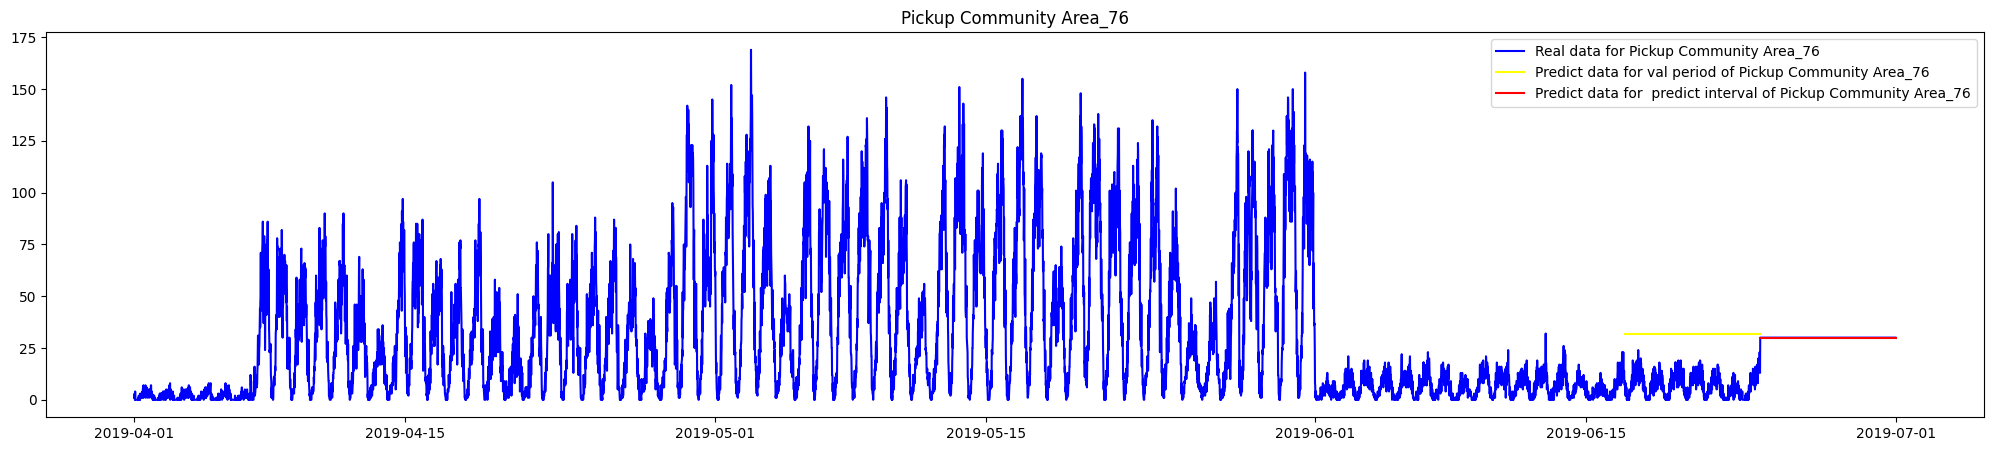

In [15]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_naive_average_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [16]:
df_naive_average_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-30 22:45:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
2019-06-30 23:00:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
2019-06-30 23:15:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
2019-06-30 23:30:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0
2019-06-30 23:45:00,16.0,1.0,1.0,3.0,1.0,1.0,10.0,5.0,84.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,2.0


Считаем МАЕ для Naive averages

In [17]:
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

3.054258241758242

Результат по модели заносим в таблицу

In [18]:
df_results.loc[ len(df_results.index )] = ['Naive averages', round(res_mae, 2)]

## Moving averages

1. For each area make a prediction with different moving averages for this area for the next 673 intervals.
2. Calculate mean absolute error (MAE) for the validation dataset.
---
1. Для каждой области сделать прогноз с разными скользящими средними для этой области на следующие 673 интервала.
2. Рассчитайте среднюю абсолютную ошибку (MAE) для проверочного набора данных.

Скользящее среднее представляет собой среднее арифметическое значение наблюдений в определенном окне или периоде, который "скользит" вдоль временного ряда.
Скользящее среднее помогает сгладить краткосрочные колебания и шумы, выявлять тренды и улавливать долгосрочные закономерности в данных.

Более подробно - по ссылке https://habr.com/ru/companies/otus/articles/728118/

Посчитаем скользящие средние значения для разных окон, от получаса до месяца ([2, 4, 96, 672, 2880]) по каждой области (т.е. столбцу) датафрейма df. Значения [2, 4, 96] не имеют предсказательного значения, поскольку маленькие окна "залезают" на тестовый набор и приведены для демонстрации различных вариантов сглаживаний. Соответственно, в таблицу результатов данные модели приведены со звездочкой (*) и при выборе наилучшей модели по МАЕ учитываться не будут.

In [19]:
df_moving_average_2_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
										  parse_dates=True)
df_moving_average_4_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
										  parse_dates=True)
df_moving_average_96_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
										   parse_dates=True)
df_moving_average_672_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
											 parse_dates=True)
df_moving_average_2880_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp',
											 parse_dates=True)

df_dict = {2: df_moving_average_2_predict,
		   4: df_moving_average_4_predict,
		   96: df_moving_average_96_predict,
		   672: df_moving_average_672_predict,
		   2880: df_moving_average_2880_predict}

In [20]:

for window in [2, 4, 96, 672, 2880]:
	df_val_predict = df.rolling(window, min_periods=1).mean()
	print(f'MAE for moving average with window = {window}:')
	df_val_predict = update_df(df_val_predict)
	res_mae = mean_absolute_error(df_val, df_val_predict[-672:])
	print(res_mae)
	if window in [2, 4, 96]:
		df_results.loc[ len(df_results.index )] = [f'* Moving averages with window {window}', round(res_mae, 2)]
	else:
		df_results.loc[ len(df_results.index )] = [f'Moving averages with window {window}', round(res_mae, 2)]

MAE for moving average with window = 2:
0.20110271672771673
MAE for moving average with window = 4:
0.2512400793650793
MAE for moving average with window = 96:
0.5944368131868131
MAE for moving average with window = 672:
0.6112828144078144
MAE for moving average with window = 2880:
1.8993437118437122


In [21]:
for window in [2, 4, 96, 672, 2880]:
	df_dict[window].fillna(0.0, inplace=True)

In [22]:
df_moving_average_4_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-24 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
for area in df:
	for window in [2, 4, 96, 672, 2880]:
		df_dict[window][area] = df_total[area].rolling(window, min_periods=1).mean()

In [24]:
for window in [2, 4, 96, 672, 2880]:
	df_dict[window] = update_df(df_dict[window])

In [25]:
df_moving_average_4_predict.head(700)

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,6.50,0.75,0.50,0.75,0.25,0.25,4.50,1.50,26.75,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.25,0.5
2019-06-24 00:15:00,9.75,1.00,0.50,1.50,0.50,0.50,6.25,2.75,45.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.00,1.0
2019-06-24 00:30:00,13.25,1.25,0.75,2.25,0.75,0.75,8.25,4.00,64.75,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.75,1.5
2019-06-24 00:45:00,16.00,1.00,1.00,3.00,1.00,1.00,10.00,5.00,84.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.00,2.0
2019-06-24 01:00:00,16.00,1.00,1.00,3.00,1.00,1.00,10.00,5.00,84.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.00,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 22:45:00,16.00,1.00,1.00,3.00,1.00,1.00,10.00,5.00,84.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.00,2.0
2019-06-30 23:00:00,16.00,1.00,1.00,3.00,1.00,1.00,10.00,5.00,84.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.00,2.0
2019-06-30 23:15:00,16.00,1.00,1.00,3.00,1.00,1.00,10.00,5.00,84.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.00,2.0


Predict for moving average with window = 2:


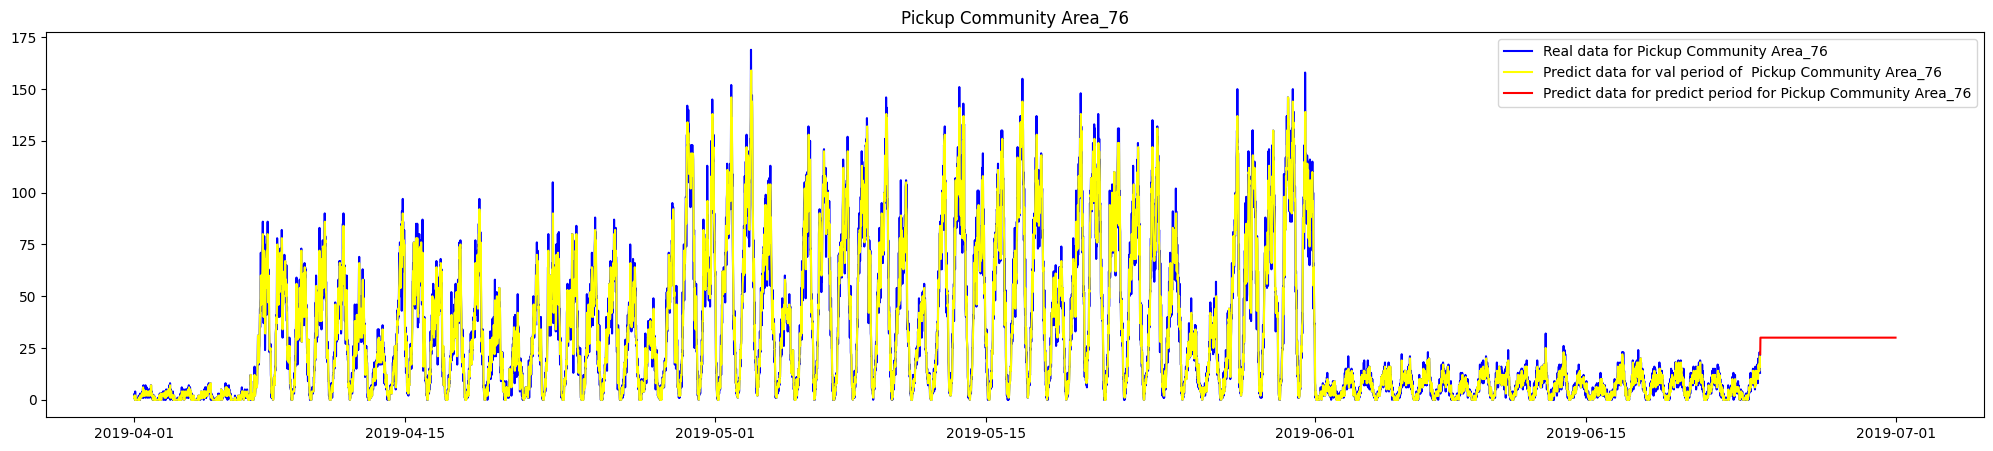

Predict for moving average with window = 4:


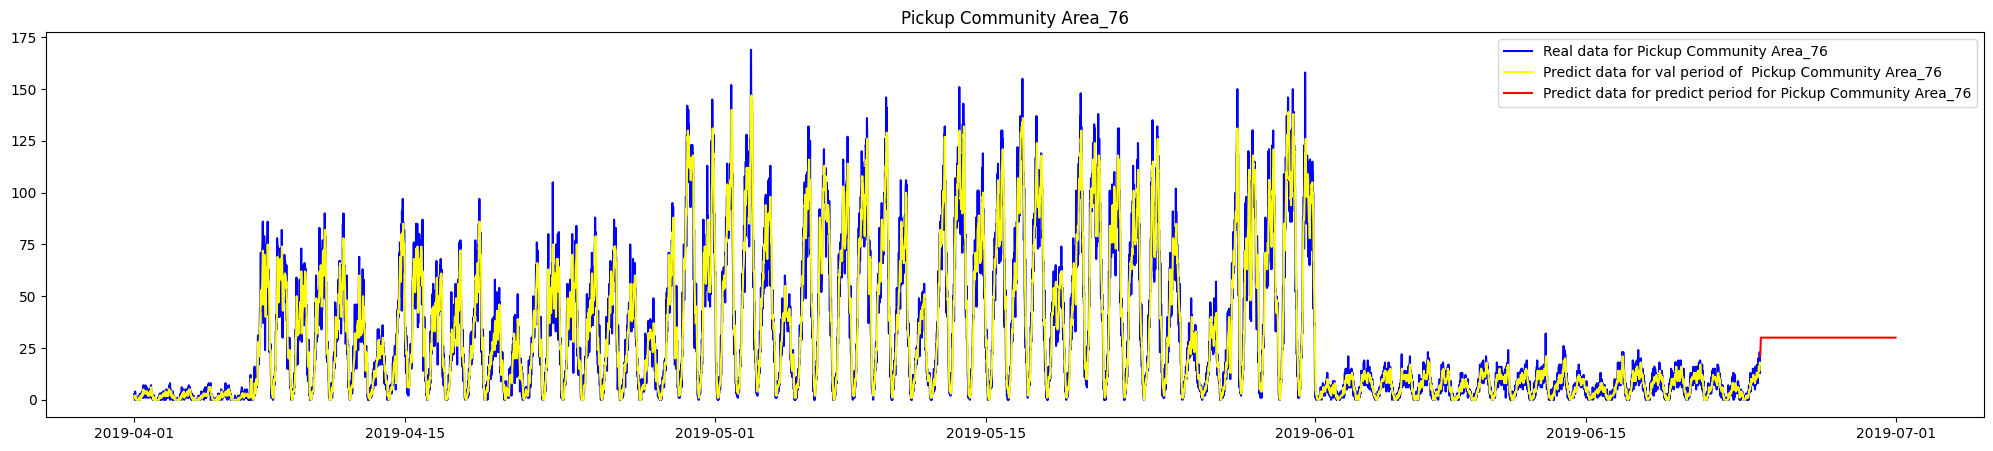

Predict for moving average with window = 96:


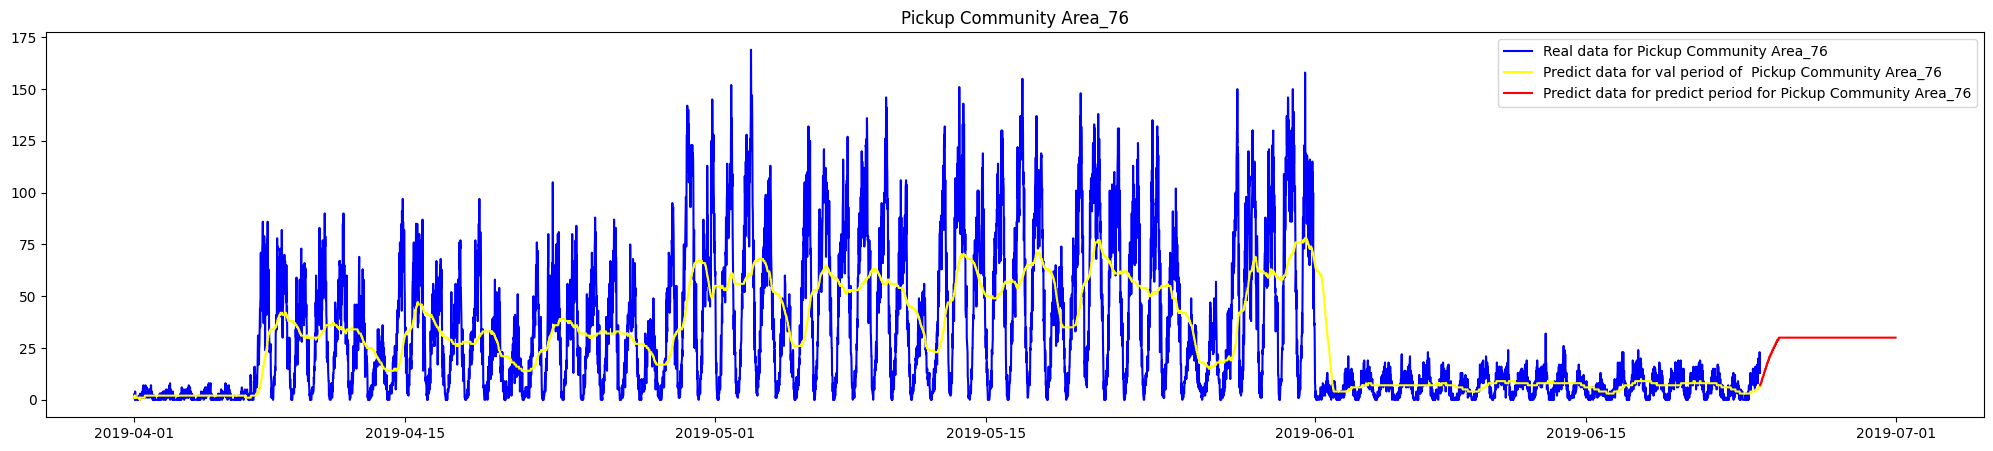

Predict for moving average with window = 672:


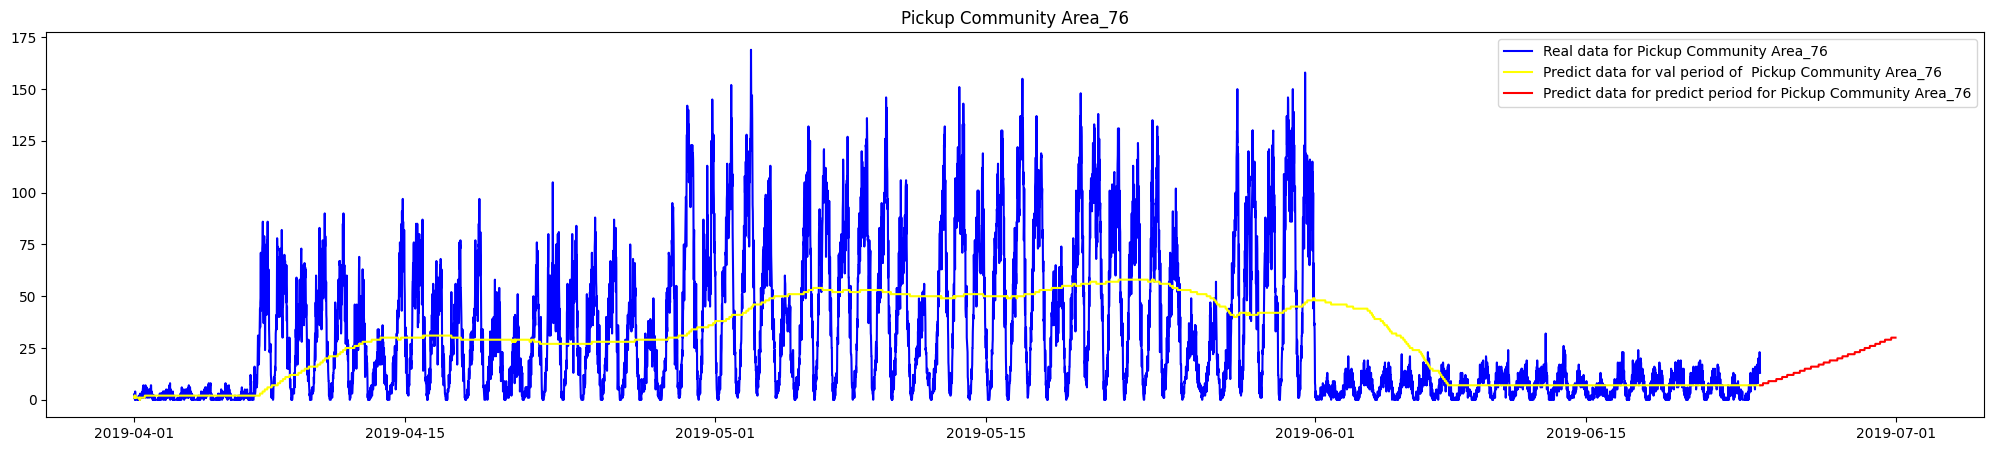

Predict for moving average with window = 2880:


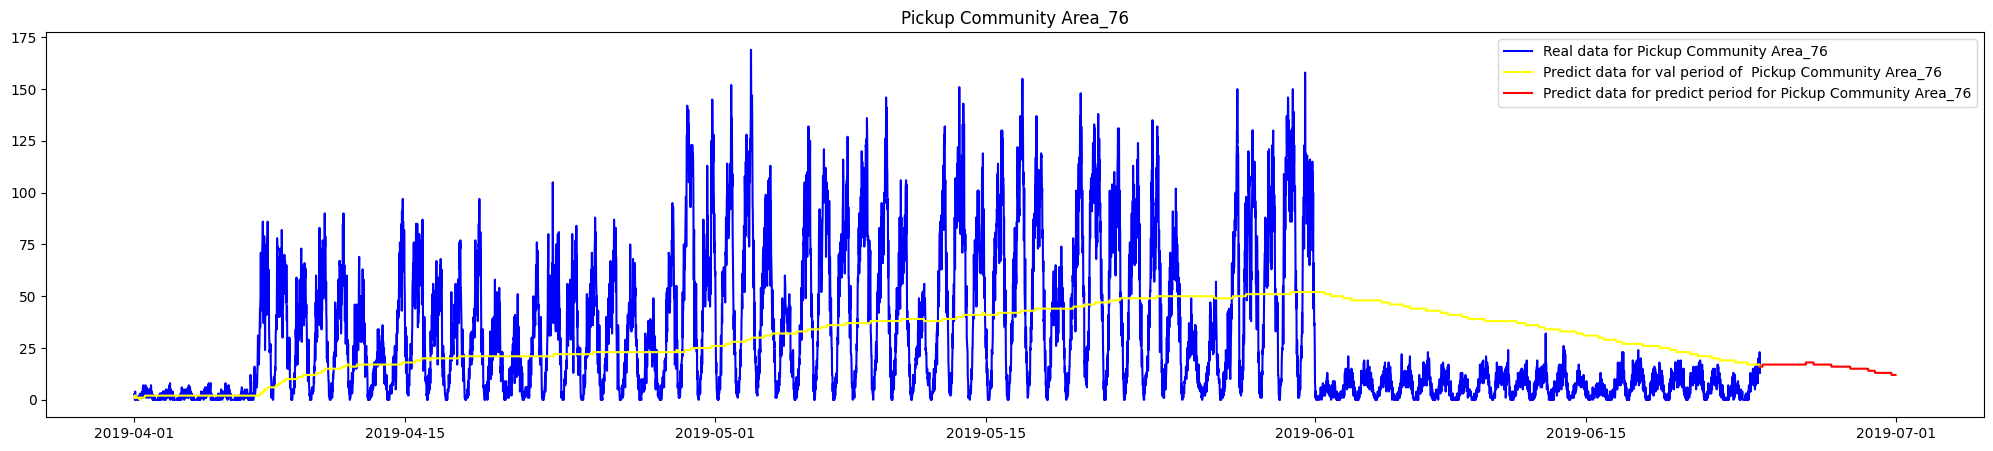

In [26]:
for area in df[df.columns[76:77]]:
	for window in [2, 4, 96, 672, 2880]:
		print(f'Predict for moving average with window = {window}:')
		df_val_predict = df.rolling(window, min_periods=1).mean()
		df_val_predict = update_df(df_val_predict)
		plt.figure(figsize=(25,5))
		plt.plot(df[area], label=f'Real data for {area}', color='blue')
		plt.plot(df_val_predict[area], label=f'Predict data for val period of  {area}', color='yellow')
		plt.plot(df_dict[window][area][-672:], label=f'Predict data for predict period for {area}', color='red')
		plt.legend(loc='best')
		plt.title(area)
		plt.show()

## Exponential smoothing

1. For each area make a prediction with 3 different exponential smoothing algorithms for this area for the next 673 intervals. Optimize the weights.
2. Calculate mean absolute error (MAE) for the validation dataset.


1. Для каждой области сделать прогноз с помощью 3 различных алгоритмов экспоненциального сглаживания для этой области на следующие 673 интервала. Оптимизируйте веса.
2. Рассчитайте среднюю абсолютную ошибку (MAE) для проверочного набора данных.

При экспоненциальном сглаживании, вместо взвешивания последних N значений ряда взвешиваются все доступные наблюдения, при этом веса по мере углубления в исторические данные экспоненциально уменьшаются.

Для анализа данных нам понадобится разложение временного ряда на компоненты - тренд, сезонность и случайные колебания.

ТРЕНД — долгосрочное изменение уровня ряда
СЕЗОННОСТЬ предполагает циклические изменения уровня ряда с постоянным периодом
СЛУЧАЙНЫЕ КОЛЕБАНИЯ — непрогнозируемое случайное изменение ряда

На примере одной из областей, посмотрим, как будет выглядеть наш временной ряд. Период - один день (4*24).

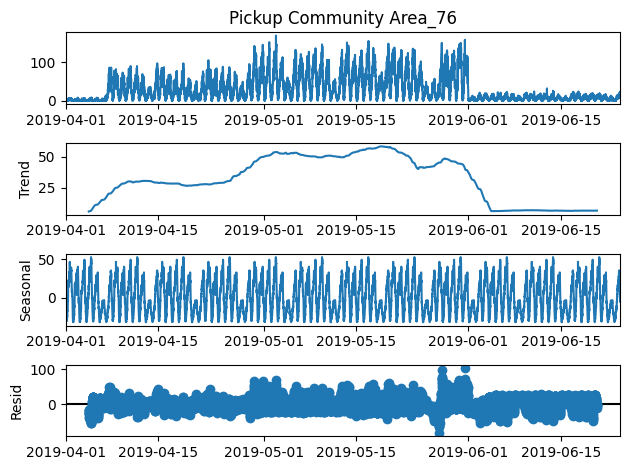

In [27]:
for area in df[df.columns[76:77]]:
	decompose_result = seasonal_decompose(df[area], period = 4*168, model='additive')
	decompose_result.plot()

Из графиков видно, что выраженный тренд отсутствует.

In [28]:
## Braun model

[Формула, используемая при простом экспоненциальном сглаживании (модель Брауна)](https://habrastorage.org/getpro/habr/formulas/4f7/f64/a26/4f7f64a262a5c514b0d9483779fcbd7b.svg)

Модельное значение является средневзвешенным между текущим истинным и предыдущим модельным значениями. Вес альфа (сглаживающий фактор) определяет, как быстро "забывается" последнее доступное истинное наблюдение. Чем меньше альфа, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд.

Подробнее - https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc431.htm

Посчитаем предикт для валидационного набора

In [29]:
df_val = df['2019-06-17':'2019-06-23'].copy()
df_val_predict = df_val.copy() * 0.0
for area in df_train:
	model_br = SimpleExpSmoothing(np.asarray(df_train[area])).fit(smoothing_level=0.2, optimized=False, use_brute=True)
	# df_val_predict[area] = model.fittedvalues[:672]
	df_val_predict[area] = model_br.forecast(672)

Преобразуем в целые неотрицательные полученные результаты

In [30]:
df_val_predict = update_df(df_val_predict)
df_val_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-17 00:00:00,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2019-06-17 00:15:00,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2019-06-17 00:30:00,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2019-06-17 00:45:00,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2019-06-17 01:00:00,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0


Посчитаем данные для предсказания данных из файла taxi_submission_file.csv

In [31]:
df_braun_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_braun_predict.fillna(0.0, inplace=True)

for area in df_train:
	model = SimpleExpSmoothing(np.asarray(df[area])).fit(smoothing_level=0.2, optimized=False, use_brute=True)
	df_braun_predict[area] = model.forecast(672)

Преобразуем в целые неотрицательные полученные результаты

In [32]:
df_braun_predict = update_df(df_braun_predict)
df_braun_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2019-06-24 00:15:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2019-06-24 00:30:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2019-06-24 00:45:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2019-06-24 01:00:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0


Построим график предсказаний для 'Pickup Community Area_76'

In [33]:
df_total = df.copy()
df_total = df_total.append(df_braun_predict)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_56594/4151968948.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_braun_predict)


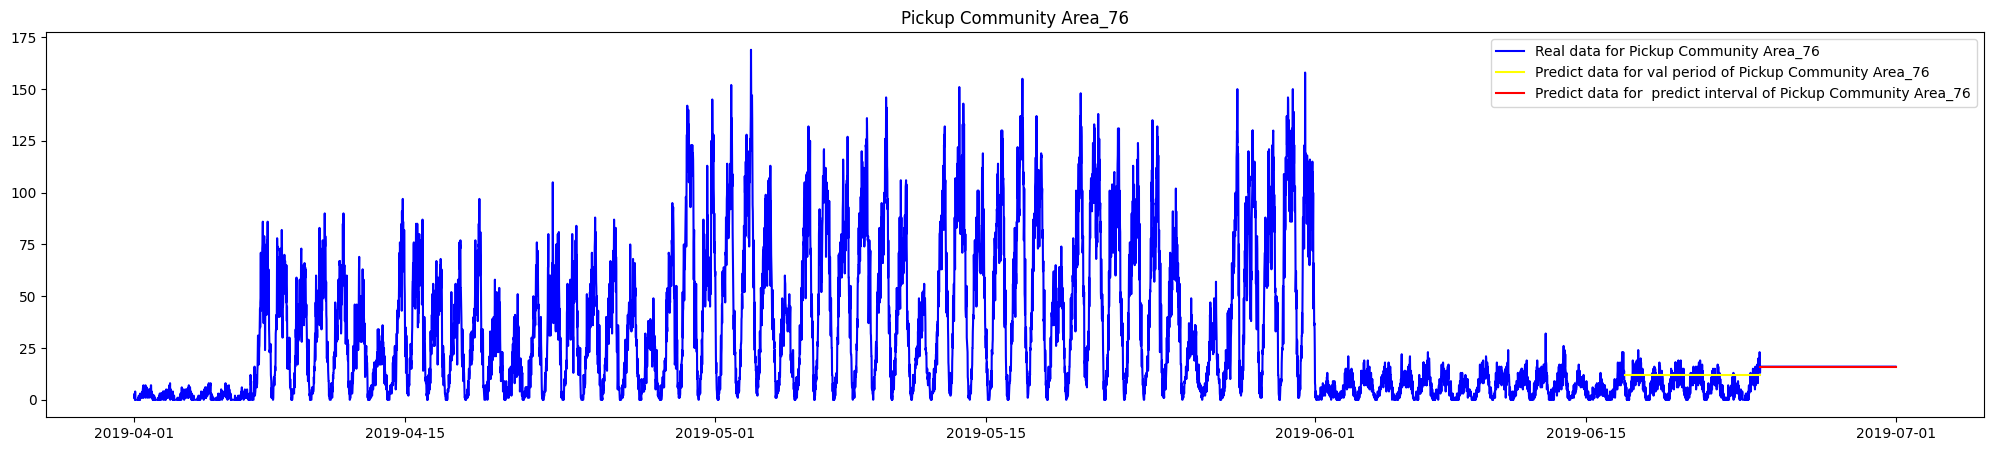

In [34]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_braun_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

Считаем МАЕ для простого экспоненциального сглаживания (модель Брауна)

In [35]:
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

0.7249313186813188

Результат по модели Брауна заносим в таблицу

In [36]:
df_results.loc[ len(df_results.index )] = ['Simple Exponential Smoothing (Braun)', round(res_mae, 2)]

In [37]:
## Holt model

Недостаток модели Брауна  - одиночное сглаживание плохо работает при наличии тренда.

В двойном эспоненциальном сглаживании (модель Хольта) (https://habrastorage.org/getpro/habr/formulas/d31/651/69a/d3165169a6e0ba0d5db61f5a788c3d7f.svg) ряд разбивается на две составляющие — уровень (level, intercept) L и тренд B (trend, slope). Уровень (ожидаемое значение ряда) предсказывался в модели Брауна. Такое же экспоненциальное сглаживание применяется к тренду, в предположении, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.
Итоговое предсказание является суммой модельных значений уровня L и тренда B.

Подробнее - https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc433.htm

Посчитаем предикт для валидационного набора

In [38]:
df_val_predict = df_val.copy() * 0.0
for area in df_train:
	model_holt = Holt(np.asarray(df_train[area])).fit(smoothing_level=0.2, smoothing_trend=0.00045, optimized=False, use_brute=True)
	df_val_predict[area] = model_holt.forecast(672)

Преобразуем в целые неотрицательные полученные результаты

In [39]:
df_val_predict = update_df(df_val_predict)
df_val_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-17 00:00:00,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2019-06-17 00:15:00,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2019-06-17 00:30:00,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2019-06-17 00:45:00,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2019-06-17 01:00:00,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0


Посчитаем данные для предсказания данных из файла taxi_submission_file.csv

In [40]:
df_holt_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_holt_predict.fillna(0.0, inplace=True)

for area in df_train:
	model_holt = Holt(np.asarray(df[area])).fit(smoothing_level=0.2, smoothing_trend=0.00045, optimized=False, use_brute=True)
	df_holt_predict[area] = model_holt.forecast(672)

Преобразуем в целые неотрицательные полученные результаты

In [41]:
df_holt_predict = update_df(df_holt_predict)
df_holt_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2019-06-24 00:15:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2019-06-24 00:30:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2019-06-24 00:45:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
2019-06-24 01:00:00,4.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0


Построим график предсказаний для 'Pickup Community Area_76'

In [42]:
df_total = df.copy()
df_total = df_total.append(df_holt_predict)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_56594/2067574991.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_holt_predict)


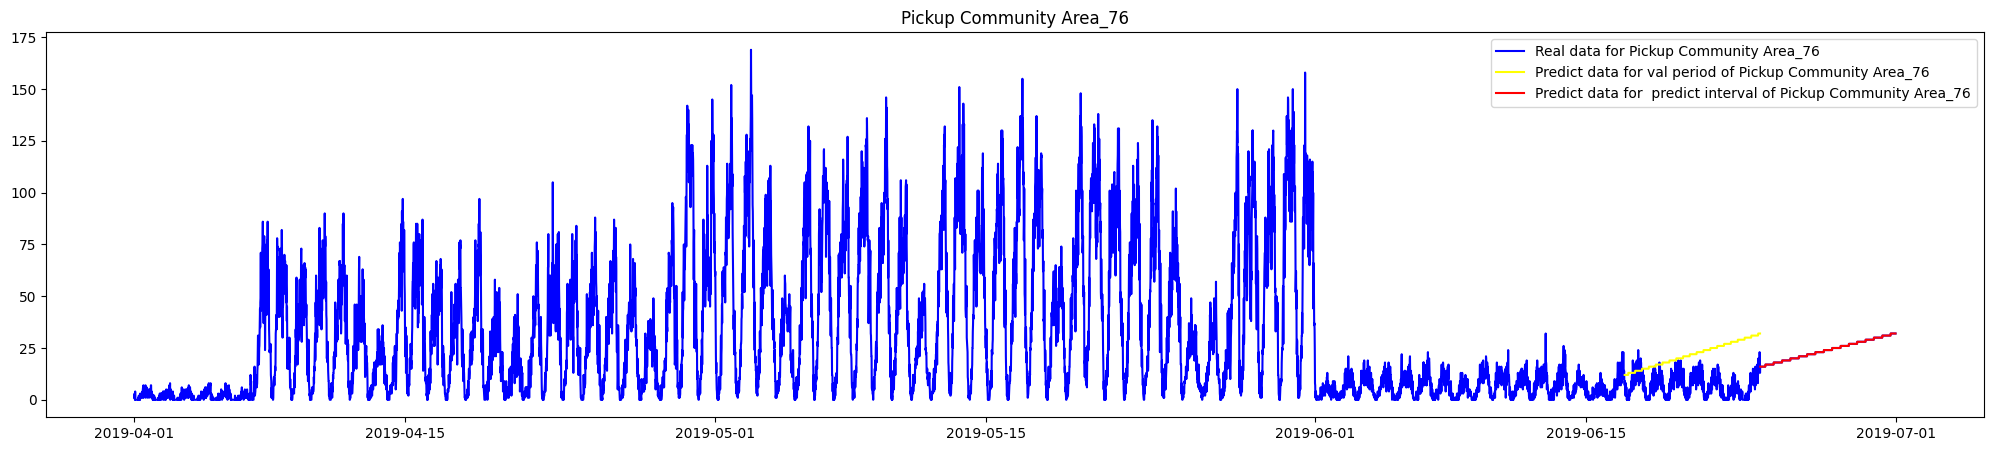

In [43]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_holt_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

Считаем МАЕ для простого экспоненциального сглаживания (модель Хольта)

In [44]:
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

0.8582684676434678

Результат по модели Хольта заносим в таблицу

In [45]:
df_results.loc[ len(df_results.index )] = ['Exponential Smoothing (Holt)', round(res_mae, 2)]

## Holt-Winters

Недостаток модели Хольта  - двойное сглаживание плохо работает при наличии сезонности.

В тройном экспоненциальном сглаживании (модель Хольта-Винтерса) добавляется третья компонента — сезонность. Сезонная компонента в модели объясняет повторяющиеся колебания вокруг уровня и тренда.
 Сезонная компонента характеризуется длиной сезона — периодом, после которого начинаются повторения колебаний.
 Формула, по которой происходят вычисления для модели: (https://habrastorage.org/getpro/habr/formulas/2f3/026/656/2f3026656c59252e10117d1df565398b.svg).
 Уровень зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, тренд остается без изменений, а сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты. При этом компоненты сглаживаются через все доступные сезоны.

Подробнее - https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm

Посчитаем предикт для валидационного набора

In [46]:
df_val_predict = df_val.copy() * 0.0
for area in df_train:
	model_es = ExponentialSmoothing(np.asarray(df_train[area]),
											seasonal_periods=4*12,
											trend="add",
											seasonal="add",
											damped_trend=True,
											use_boxcox=1.01,
											initialization_method="estimated")
		# .fit(use_brute=True, smoothing_level=0.2, smoothing_trend=0.00045, smoothing_seasonal=0.35)
	res = model_es.fit(use_brute=True, smoothing_level=0.2, smoothing_trend=0.00045, smoothing_seasonal=0.35)
	df_val_predict[area] = res.forecast(672)

Преобразуем в целые неотрицательные полученные результаты

In [47]:
df_val_predict = update_df(df_val_predict)
df_val_predict = df_val_predict.fillna(0)
df_val_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-17 00:00:00,7.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
2019-06-17 00:15:00,3.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
2019-06-17 00:30:00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2019-06-17 00:45:00,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0
2019-06-17 01:00:00,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0


Посчитаем данные для предсказания данных из файла taxi_submission_file.csv

In [48]:
df_holt_winters_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_holt_winters_predict.fillna(0.0, inplace=True)

for area in df:
	model_es = ExponentialSmoothing(np.asarray(df[area]),
											seasonal_periods=4*12,
											trend="add",
											seasonal="add",
											damped_trend=True,
											use_boxcox=1.01,
											initialization_method="estimated").fit(use_brute=True, smoothing_level=0.2, smoothing_trend=0.00045, smoothing_seasonal=0.35)
	df_holt_winters_predict[area] = model_es.forecast(672)

Преобразуем в целые неотрицательные полученные результаты

In [49]:
df_holt_winters_predict = df_holt_winters_predict.fillna(0)
df_holt_winters_predict = update_df(df_holt_winters_predict)
df_holt_winters_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-24 00:00:00,4.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0
2019-06-24 00:15:00,4.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,1.0
2019-06-24 00:30:00,4.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0
2019-06-24 00:45:00,4.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1.0
2019-06-24 01:00:00,3.0,1.0,0.0,1.0,0.0,0.0,3.0,1.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0


Построим график предсказаний для 'Pickup Community Area_76'

In [50]:
df_total = df.copy()
df_total = df_total.append(df_holt_winters_predict)

/var/folders/qt/7hmdvpc92k32ffm5qkp9k79m0000gn/T/ipykernel_56594/2217355837.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_total.append(df_holt_winters_predict)


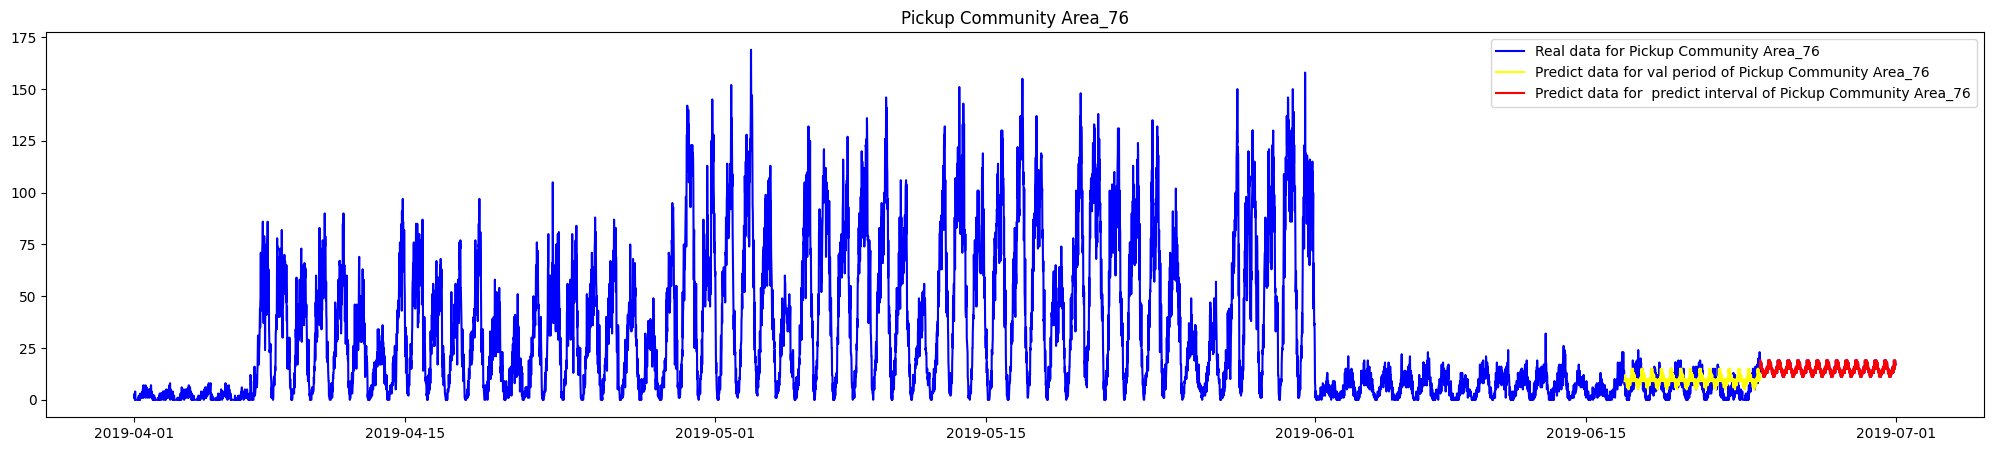

In [51]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_holt_winters_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

Считаем МАЕ для простого экспоненциального сглаживания (модель Хольта-Винтерса)

In [52]:
# df_val_predict = df_val_predict.fillna(0)
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

0.7658348595848594

Результат по модели Хольта-Винтерса заносим в таблицу

In [53]:
df_results.loc[ len(df_results.index )] = ['Exponential Smoothing (Holt-Winters)', round(res_mae, 2)]

## ARIMA

1. For each area make a prediction with the best SARIMA model according to AIC metrics for this area for the next 673 intervals.
2. Calculate mean absolute error (MAE) for the validation dataset.


1. Для каждой области сделать прогноз с помощью лучшей модели SARIMA по метрикам AIC для этой области на следующие 673 интервала.
2. Рассчитайте среднюю абсолютную ошибку (MAE) для проверочного набора данных.

ARMA - AutoRegressive + Moving Average.

Формула Autoregressive Model:
$y_t = c + \varphi  \cdot y_{t-1}$, где $c$ — константа, $\varphi$ — вес модели, $y_{t–1}$ — значение в период (t – 1)

Т.е. в качестве признаков в модели обычной регрессии используются значения той же переменной, но за предыдущие периоды. Сколько предыдущих периодов использовать определяется параметром p и записывается как AR(p).

Модель скользящего среднего (Moving Average, MA) помогает учесть случайные колебания или отклонения (ошибки) истинного значения от прогнозируемого, т.е. модель скользящего среднего — авторегрессия на ошибку.
Формула Moving Average
$y_t = \mu + \varphi \cdot \varepsilon_{t-1}$, где $\mu$ — среднее значение временного ряда, $\varphi$ — вес модели, $\varepsilon_{t-1}$ — ошибка в период t – 1.

Приведенная формула является моделью скользящего среднего с параметром q = 1 или MA(1). Параметр q может принимать и другие значения (MA(q)).
!!! Модель скользящего среднего НЕ скользящее среднее временного ряда, которое рассматривалось ранее. !!!

Модель ARMA(p, q) описывает любой стационарный (т.е. в данных отсутствует тренд и сезонность) временной ряд.

---
Если данные НЕ стационарны, то используются другие модели:

ARIMA - Autoregressive Model + Integrated + Moving Average
Компонента Integrated (I) отвечает за удаление тренда (сам процесс называется дифференцированием).

SARIMA - Seasonality + Autoregressive Model + Integrated + Moving Average
 Компонента Seasonality (S) учитывает сезонность в данных.

SARIMAX - Seasonality + Autoregressive + Integrated + Moving Average + eXogenous factors
Компонента eXogenous factors(X) - это внешние или экзогенные факторы, которые напрямую не учитываются моделью, но влияют на нее.



При анализе в разделе Экспоненциальное сглаживание из графика разложения временного ряда на компоненты, выяснили, что выраженный тренд у ряда отсутствует.

Определим Стационарность (stationarity) нашего временного ряда, т.е., что компоненты тренд и сезонность отсутствуют. Другими словами, что среднее значение и дисперсия не меняются со смещением во времени.



Для точной оценки стационарности применим тест Дики-Фуллера (Dickey-Fuller test). Подробнее о тесте - https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0 и https://www.codecamp.ru/blog/dickey-fuller-test-python/

Нулевая гипотеза предполагает, что процесс нестационарный.
Альтернативная гипотеза соответственно говорит об обратном.
Пороговое значение возьмем равным 0,05 (5%).

In [54]:
n = 0
for area in df:
	p = sm.tsa.stattools.adfuller(df[area])[1]
	print(f'p for {area}: {p}')
	if p > 0.05:
		print(f'Ряд по области {area} не является стационарным. По критерию Дики-Фуллера p-value = {p}')
if n == 0:
	print(f'Ряды по всем областям являются стационарными. По критерию Дики-Фуллера p-value <= 0.05')

p for Pickup Community Area_0: 2.764286553468534e-13
p for Pickup Community Area_1: 2.8643147547667897e-19
p for Pickup Community Area_2: 1.847994982242554e-19
p for Pickup Community Area_3: 2.398595698557342e-16
p for Pickup Community Area_4: 1.169466940485968e-15
p for Pickup Community Area_5: 7.139668523943716e-14
p for Pickup Community Area_6: 5.99418360019844e-13
p for Pickup Community Area_7: 1.3651481402408681e-08
p for Pickup Community Area_8: 8.497282814023744e-18
p for Pickup Community Area_9: 0.0
p for Pickup Community Area_10: 9.802518652112375e-20
p for Pickup Community Area_11: 6.975263414718075e-10
p for Pickup Community Area_12: 9.418959924514728e-23
p for Pickup Community Area_13: 8.666477516725525e-23
p for Pickup Community Area_14: 3.5932960015507106e-12
p for Pickup Community Area_15: 2.862457568356834e-20
p for Pickup Community Area_16: 1.878988856768927e-07
p for Pickup Community Area_17: 5.6883856577980994e-21
p for Pickup Community Area_18: 6.224704426340319e-30

In [55]:
gc.collect()

23220

Параметры SARIMA модели будем искать с помощью auto_arima на примере области 'Pickup Community Area_76'.
Подробнее - https://alkaline-ml.com/pmdarima/tips_and_tricks.html


Оценка моделей с разными параметрами происходит с помощью информационного критерий Акаике (Akaike Information Criterion)
Оценка по информационному критерию Акаике награждает модели, которые достигают высокого показателя критерия адекватности (с низким максимальным правдоподобием), и штрафует модели, если они становятся чрезмерно сложными (большое количество параметров $k$):
                            $\large{AIC = 2*k - ln(ML)}$

In [56]:
model_s = pm.auto_arima(df['Pickup Community Area_76'],
						# start_p=0, start_q=0,
						test='adf',
						# max_p=2, max_q=2,
						# m=4,
						# start_P=0, start_Q=0,
						seasonal=False,
						d=0, D=0,
						trace=True,
						error_action='ignore',
						information_criterion='aic',
						suppress_warnings=True,
						scoring='mae',
						stepwise=True)

model_s.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=59007.841, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=84418.677, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=59933.276, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=76235.268, Time=0.48 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=59005.776, Time=0.78 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=70920.736, Time=1.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=59003.845, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=59005.745, Time=0.61 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=59168.169, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=58975.299, Time=0.81 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=72317.697, Time=0.99 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=59854.786, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=58977.281, Time=1.28 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=58977.275, Time=1.61 sec
 ARIMA(0,0,0)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8064
Model:               SARIMAX(5, 0, 5)   Log Likelihood              -29346.505
Date:                Sat, 06 May 2023   AIC                          58717.010
Time:                        02:28:26   BIC                          58800.952
Sample:                    04-01-2019   HQIC                         58745.730
                         - 06-23-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6057      0.127      4.766      0.000       0.357       0.855
ar.L1          0.1213      0.098      1.235      0.217      -0.071       0.314
ar.L2          1.1634      0.100     11.639      0.000       0.967       1.359
ar.L3          0.3652      0.098      3.726      0.000       0.173       0.557
ar.L4         -0.2425      0.067     -3.606      0.000      -0.374      -0.111
ar.L5         -0.4273      0.053     -8.054      0.000      -0.531      -0.323
ma.L1          0.4907      0.098      5.032      0.000       0.300       0.682
ma.L2         -0.6625      0.060    -11.098      0.000      -0.780      -0.546
ma.L3         -0.5728      0.079     -7.212      0.000      -0.728      -0.417
ma.L4         -0.0390      0.048     -0.817      0.414      -0.133       0.055
ma.L5          0.2635      0.026     10.088      0.000       0.212       0.315
sigma2        85.1251      0.811    105.001      0.000      83.536      86.714
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              5100.67
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

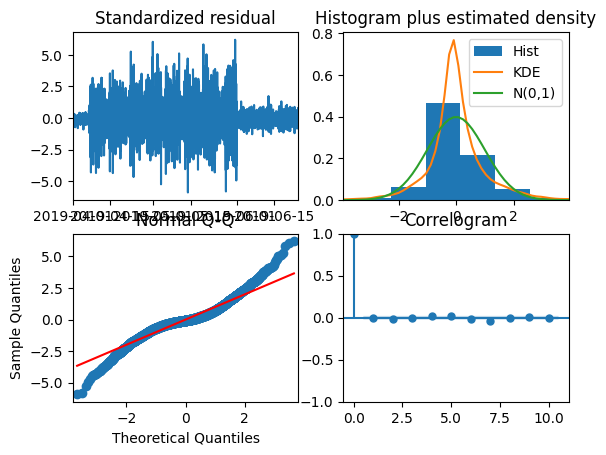

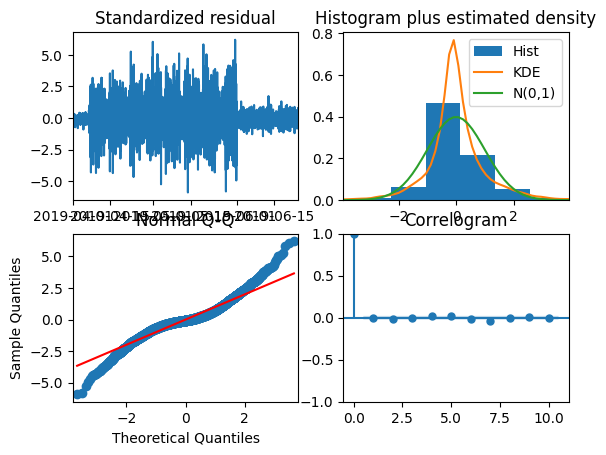

In [57]:
model_s.plot_diagnostics()

Посчитаем предикт для валидационного набора с учетом найденных параметров для SARIMAX, принудительно отключив предупреждения системы

In [58]:
warnings.simplefilter(action = 'ignore', category = Warning)

df_val_predict = df_val.copy() * 0.0
for area in df_train:
	model_arima = SARIMAX(np.asarray(df_train[area]), order=(5, 0, 5), seasonal_order=(0, 0, 0, 0))
	sarima_ = model_arima.fit()
	df_val_predict[area] = sarima_.get_prediction(start=len(df_train[area]), end=len(df_train[area]) + 671).predicted_mean

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04024D+00    |proj g|=  2.85481D-01

At iterate    5    f=  3.03881D+00    |proj g|=  1.85481D-02

At iterate   10    f=  3.03872D+00    |proj g|=  2.42626D-02

At iterate   15    f=  3.03830D+00    |proj g|=  8.47913D-02

At iterate   20    f=  3.03802D+00    |proj g|=  3.66148D-02

At iterate   25    f=  3.03792D+00    |proj g|=  3.42805D-03

At iterate   30    f=  3.03777D+00    |proj g|=  5.06031D-02

At iterate   35    f=  3.03760D+00    |proj g|=  6.21558D-03

At iterate   40    f=  3.03735D+00    |proj g|=  3.20014D-02

At iterate   45    f=  3.03730D+00    |proj g|=  3.77105D-03

At iterate   50    f=  3.03715D+00    |proj g|=  3.31243D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.64740D+00    |proj g|=  3.22717D-02

At iterate   10    f=  1.64559D+00    |proj g|=  1.23661D-02

At iterate   15    f=  1.64525D+00    |proj g|=  1.84242D-04

At iterate   20    f=  1.64524D+00    |proj g|=  3.89998D-03

At iterate   25    f=  1.64516D+00    |proj g|=  1.66379D-03

At iterate   30    f=  1.64515D+00    |proj g|=  3.83745D-04

At iterate   35    f=  1.64514D+00    |proj g|=  3.67177D-03

At iterate   40    f=  1.64508D+00    |proj g|=  3.59261D-03

At iterate   45    f=  1.64506D+00    |proj g|=  4.87176D-04

At iterate   50    f=  1.64506D+00    |proj g|=  1.26993D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.63016D+00    |proj g|=  7.75003D-04

At iterate   10    f=  1.63014D+00    |proj g|=  2.95742D-04

At iterate   15    f=  1.63011D+00    |proj g|=  4.55305D-03

At iterate   20    f=  1.63005D+00    |proj g|=  1.29529D-04

At iterate   25    f=  1.63005D+00    |proj g|=  2.65953D-04

At iterate   30    f=  1.63003D+00    |proj g|=  1.73101D-03

At iterate   35    f=  1.63002D+00    |proj g|=  1.94970D-03

At iterate   40    f=  1.63001D+00    |proj g|=  1.78571D-04

At iterate   45    f=  1.63001D+00    |proj g|=  1.08799D-04

At iterate   50    f=  1.63001D+00    |proj g|=  6.25695D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.08662D+00    |proj g|=  3.93752D-02

At iterate   10    f=  2.07711D+00    |proj g|=  1.57218D-02

At iterate   15    f=  2.07604D+00    |proj g|=  5.16569D-04

At iterate   20    f=  2.07603D+00    |proj g|=  2.36719D-03

At iterate   25    f=  2.07599D+00    |proj g|=  5.83281D-04

At iterate   30    f=  2.07597D+00    |proj g|=  3.40481D-03

At iterate   35    f=  2.07586D+00    |proj g|=  1.12323D-02

At iterate   40    f=  2.07570D+00    |proj g|=  1.18108D-03

At iterate   45    f=  2.07570D+00    |proj g|=  5.00831D-04

At iterate   50    f=  2.07564D+00    |proj g|=  7.24006D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44661D+00    |proj g|=  5.53171D-03

At iterate    5    f=  1.44659D+00    |proj g|=  7.02000D-04

At iterate   10    f=  1.44657D+00    |proj g|=  1.69808D-03

At iterate   15    f=  1.44657D+00    |proj g|=  2.22227D-04

At iterate   20    f=  1.44655D+00    |proj g|=  4.54878D-03

At iterate   25    f=  1.44649D+00    |proj g|=  1.77178D-03

At iterate   30    f=  1.44649D+00    |proj g|=  4.23369D-04

At iterate   35    f=  1.44649D+00    |proj g|=  4.08242D-04

At iterate   40    f=  1.44648D+00    |proj g|=  2.92901D-03

At iterate   45    f=  1.44647D+00    |proj g|=  2.72618D-04

At iterate   50    f=  1.44647D+00    |proj g|=  2.11694D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.20993D+00    |proj g|=  3.60032D-03

At iterate   10    f=  1.20988D+00    |proj g|=  5.63749D-03

At iterate   15    f=  1.20982D+00    |proj g|=  3.79884D-04

At iterate   20    f=  1.20980D+00    |proj g|=  2.30010D-03

At iterate   25    f=  1.20979D+00    |proj g|=  4.29794D-05

At iterate   30    f=  1.20979D+00    |proj g|=  1.34909D-04

At iterate   35    f=  1.20978D+00    |proj g|=  1.15288D-03

At iterate   40    f=  1.20977D+00    |proj g|=  5.14993D-04

At iterate   45    f=  1.20976D+00    |proj g|=  1.32999D-03

At iterate   50    f=  1.20975D+00    |proj g|=  8.70544D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.91950D+00    |proj g|=  3.25055D-02

At iterate   10    f=  2.91293D+00    |proj g|=  5.68488D-03

At iterate   15    f=  2.90874D+00    |proj g|=  2.61315D-02

At iterate   20    f=  2.90447D+00    |proj g|=  5.83516D-03

At iterate   25    f=  2.90418D+00    |proj g|=  2.37284D-03

At iterate   30    f=  2.90322D+00    |proj g|=  6.30626D-03

At iterate   35    f=  2.90315D+00    |proj g|=  7.35462D-04

At iterate   40    f=  2.90315D+00    |proj g|=  4.55109D-04

At iterate   45    f=  2.90314D+00    |proj g|=  1.06659D-03

At iterate   50    f=  2.90312D+00    |proj g|=  2.10226D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46773D+00    |proj g|=  4.73530D-03

At iterate    5    f=  2.46769D+00    |proj g|=  9.90349D-04

At iterate   10    f=  2.46763D+00    |proj g|=  1.74444D-03

At iterate   15    f=  2.46750D+00    |proj g|=  4.65613D-03

At iterate   20    f=  2.46744D+00    |proj g|=  7.57052D-04

At iterate   25    f=  2.46731D+00    |proj g|=  1.35492D-03

At iterate   30    f=  2.46730D+00    |proj g|=  3.28578D-04

At iterate   35    f=  2.46729D+00    |proj g|=  5.34230D-04

At iterate   40    f=  2.46726D+00    |proj g|=  1.46461D-03

At iterate   45    f=  2.46719D+00    |proj g|=  2.16420D-03

At iterate   50    f=  2.46717D+00    |proj g|=  7.28295D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  4.11720D+00    |proj g|=  2.60061D-03

At iterate   10    f=  4.11664D+00    |proj g|=  4.98374D-03

At iterate   15    f=  4.11658D+00    |proj g|=  7.33749D-04

At iterate   20    f=  4.11656D+00    |proj g|=  1.89684D-03

At iterate   25    f=  4.11653D+00    |proj g|=  2.24786D-03

At iterate   30    f=  4.11649D+00    |proj g|=  1.42022D-03

At iterate   35    f=  4.11649D+00    |proj g|=  3.92799D-04

At iterate   40    f=  4.11649D+00    |proj g|=  3.03605D-04

At iterate   45    f=  4.11648D+00    |proj g|=  6.87377D-04

At iterate   50    f=  4.11648D+00    |proj g|=  3.72441D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -6.11236D-01    |proj g|=  6.37517D-03

At iterate   10    f= -6.11318D-01    |proj g|=  6.00058D-03

At iterate   15    f= -6.11771D-01    |proj g|=  9.42804D-02

At iterate   20    f= -6.12319D-01    |proj g|=  1.69035D-01

At iterate   25    f= -6.14378D-01    |proj g|=  1.46969D-01

At iterate   30    f= -6.14670D-01    |proj g|=  4.86503D-03

At iterate   35    f= -6.14715D-01    |proj g|=  5.72375D-03

At iterate   40    f= -6.14720D-01    |proj g|=  8.99140D-03

At iterate   45    f= -6.14815D-01    |proj g|=  2.12856D-02

At iterate   50    f= -6.14881D-01    |proj g|=  2.71868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53951D-01    |proj g|=  1.24709D-02

At iterate    5    f=  7.53625D-01    |proj g|=  6.53511D-03

At iterate   10    f=  7.52945D-01    |proj g|=  1.96994D-02

At iterate   15    f=  7.52649D-01    |proj g|=  1.57204D-03

At iterate   20    f=  7.52623D-01    |proj g|=  4.69208D-03

At iterate   25    f=  7.52597D-01    |proj g|=  1.82060D-03

At iterate   30    f=  7.52588D-01    |proj g|=  1.08757D-03

At iterate   35    f=  7.52549D-01    |proj g|=  5.57144D-03

At iterate   40    f=  7.52517D-01    |proj g|=  1.69958D-03

At iterate   45    f=  7.52513D-01    |proj g|=  1.25992D-03

At iterate   50    f=  7.52480D-01    |proj g|=  5.97608D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.25738D+00    |proj g|=  1.48852D-03

At iterate   10    f=  1.25729D+00    |proj g|=  8.63050D-04

At iterate   15    f=  1.25728D+00    |proj g|=  9.87245D-04

At iterate   20    f=  1.25720D+00    |proj g|=  4.40335D-03

At iterate   25    f=  1.25718D+00    |proj g|=  3.67750D-04

At iterate   30    f=  1.25718D+00    |proj g|=  1.04949D-03

At iterate   35    f=  1.25713D+00    |proj g|=  5.92932D-03

At iterate   40    f=  1.25705D+00    |proj g|=  1.74020D-03

At iterate   45    f=  1.25703D+00    |proj g|=  2.24593D-03

At iterate   50    f=  1.25701D+00    |proj g|=  6.37759D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61040D-01    |proj g|=  3.81290D-01

At iterate    5    f=  4.16708D-01    |proj g|=  4.86665D-02

At iterate   10    f=  3.91255D-01    |proj g|=  6.43747D-02

At iterate   15    f=  3.86738D-01    |proj g|=  1.04841D-02

At iterate   20    f=  3.86717D-01    |proj g|=  7.19592D-04

At iterate   25    f=  3.86703D-01    |proj g|=  1.78509D-03

At iterate   30    f=  3.86695D-01    |proj g|=  2.00865D-03

At iterate   35    f=  3.86679D-01    |proj g|=  8.61712D-04

At iterate   40    f=  3.86678D-01    |proj g|=  1.03570D-03

At iterate   45    f=  3.86665D-01    |proj g|=  2.19224D-03

At iterate   50    f=  3.86536D-01    |proj g|=  1.66415D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84272D-01    |proj g|=  3.05854D-02

At iterate    5    f=  7.83701D-01    |proj g|=  1.33664D-02

At iterate   10    f=  7.83599D-01    |proj g|=  2.27173D-03

At iterate   15    f=  7.83559D-01    |proj g|=  1.75038D-04

At iterate   20    f=  7.83546D-01    |proj g|=  6.58420D-03

At iterate   25    f=  7.83522D-01    |proj g|=  4.36069D-04

At iterate   30    f=  7.83512D-01    |proj g|=  3.99129D-03

At iterate   35    f=  7.83482D-01    |proj g|=  2.87506D-03

At iterate   40    f=  7.83481D-01    |proj g|=  3.99504D-04

At iterate   45    f=  7.83479D-01    |proj g|=  1.24032D-03

At iterate   50    f=  7.83475D-01    |proj g|=  2.94561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.21540D+00    |proj g|=  3.72128D-02

At iterate   10    f=  1.21155D+00    |proj g|=  9.66924D-03

At iterate   15    f=  1.21124D+00    |proj g|=  8.37819D-04

At iterate   20    f=  1.21120D+00    |proj g|=  5.57692D-03

At iterate   25    f=  1.21107D+00    |proj g|=  7.69588D-04

At iterate   30    f=  1.21104D+00    |proj g|=  3.11967D-03

At iterate   35    f=  1.21094D+00    |proj g|=  1.95266D-03

At iterate   40    f=  1.21093D+00    |proj g|=  2.09882D-03

At iterate   45    f=  1.21086D+00    |proj g|=  1.11504D-03

At iterate   50    f=  1.21085D+00    |proj g|=  8.30755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.07420D+00    |proj g|=  4.62159D-03

At iterate   10    f=  1.07400D+00    |proj g|=  2.87725D-03

At iterate   15    f=  1.07390D+00    |proj g|=  3.84985D-03

At iterate   20    f=  1.07342D+00    |proj g|=  7.91767D-03

At iterate   25    f=  1.07328D+00    |proj g|=  6.78551D-04

At iterate   30    f=  1.07328D+00    |proj g|=  2.70931D-04

At iterate   35    f=  1.07328D+00    |proj g|=  5.29528D-04

At iterate   40    f=  1.07319D+00    |proj g|=  9.42998D-03

At iterate   45    f=  1.07315D+00    |proj g|=  1.28884D-03

At iterate   50    f=  1.07306D+00    |proj g|=  2.10754D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.45245D+00    |proj g|=  2.41578D-03

At iterate   10    f=  1.45228D+00    |proj g|=  5.13083D-03

At iterate   15    f=  1.45224D+00    |proj g|=  2.71260D-04

At iterate   20    f=  1.45223D+00    |proj g|=  3.48711D-03

At iterate   25    f=  1.45185D+00    |proj g|=  5.78786D-03

At iterate   30    f=  1.45164D+00    |proj g|=  4.21760D-03

At iterate   35    f=  1.45160D+00    |proj g|=  1.42798D-03

At iterate   40    f=  1.45159D+00    |proj g|=  1.81108D-03

At iterate   45    f=  1.45155D+00    |proj g|=  3.70897D-03

At iterate   50    f=  1.45153D+00    |proj g|=  2.23837D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.25266D-01    |proj g|=  1.10411D-02

At iterate   10    f=  3.24721D-01    |proj g|=  6.65889D-03

At iterate   15    f=  3.24315D-01    |proj g|=  2.20379D-03

At iterate   20    f=  3.24166D-01    |proj g|=  2.28467D-03

At iterate   25    f=  3.24117D-01    |proj g|=  7.95538D-03

At iterate   30    f=  3.24099D-01    |proj g|=  1.41451D-03

At iterate   35    f=  3.23993D-01    |proj g|=  1.17604D-02

At iterate   40    f=  3.23632D-01    |proj g|=  9.60164D-03

At iterate   45    f=  3.23521D-01    |proj g|=  2.01381D-03

At iterate   50    f=  3.23088D-01    |proj g|=  4.64166D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.63212D-01    |proj g|=  1.90476D-02

At iterate   10    f= -3.65770D-01    |proj g|=  3.98807D-02

At iterate   15    f= -3.66347D-01    |proj g|=  1.00585D-02

At iterate   20    f= -3.66369D-01    |proj g|=  8.73597D-04

At iterate   25    f= -3.66471D-01    |proj g|=  1.31403D-02

At iterate   30    f= -3.66688D-01    |proj g|=  3.10724D-03

At iterate   35    f= -3.66902D-01    |proj g|=  2.38082D-02
  ys=-4.747E-05  -gs= 1.700E-05 BFGS update SKIPPED

At iterate   40    f= -3.66971D-01    |proj g|=  3.26420D-03

At iterate   45    f= -3.67081D-01    |proj g|=  1.06026D-02

At iterate   50    f= -3.67169D-01    |proj g|=  1.60548D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  4.83782D-01    |proj g|=  9.59337D-02

At iterate   10    f=  4.81096D-01    |proj g|=  1.73578D-02

At iterate   15    f=  4.79999D-01    |proj g|=  2.51375D-02

At iterate   20    f=  4.78655D-01    |proj g|=  1.34349D-02

At iterate   25    f=  4.78351D-01    |proj g|=  7.60525D-03

At iterate   30    f=  4.78047D-01    |proj g|=  1.02995D-02

At iterate   35    f=  4.77721D-01    |proj g|=  9.60524D-03

At iterate   40    f=  4.77452D-01    |proj g|=  8.43634D-03

At iterate   45    f=  4.77415D-01    |proj g|=  7.75949D-03

At iterate   50    f=  4.77378D-01    |proj g|=  2.62000D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00360D-01    |proj g|=  2.42554D-01

At iterate    5    f=  8.40689D-02    |proj g|=  1.98757D-02

At iterate   10    f=  6.91119D-02    |proj g|=  2.12933D-01

At iterate   15    f=  5.87945D-02    |proj g|=  2.92881D-02

At iterate   20    f=  5.62275D-02    |proj g|=  1.10632D-02

At iterate   25    f=  5.61083D-02    |proj g|=  4.58774D-03

At iterate   30    f=  5.59831D-02    |proj g|=  3.79328D-03

At iterate   35    f=  5.59035D-02    |proj g|=  2.30681D-03

At iterate   40    f=  5.58950D-02    |proj g|=  1.55218D-03

At iterate   45    f=  5.58484D-02    |proj g|=  5.87723D-03

At iterate   50    f=  5.57562D-02    |proj g|=  1.09120D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.30266D+00    |proj g|=  1.92159D-03

At iterate   10    f=  1.30249D+00    |proj g|=  2.69260D-03

At iterate   15    f=  1.30247D+00    |proj g|=  8.70480D-04

At iterate   20    f=  1.30245D+00    |proj g|=  1.03002D-03

At iterate   25    f=  1.30245D+00    |proj g|=  7.14820D-05

At iterate   30    f=  1.30244D+00    |proj g|=  1.49703D-03

At iterate   35    f=  1.30244D+00    |proj g|=  7.65933D-04

At iterate   40    f=  1.30244D+00    |proj g|=  2.91948D-04

At iterate   45    f=  1.30244D+00    |proj g|=  1.63612D-04

At iterate   50    f=  1.30244D+00    |proj g|=  3.14784D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.55255D+00    |proj g|=  6.27147D-04

At iterate   10    f=  1.55254D+00    |proj g|=  8.61748D-04

At iterate   15    f=  1.55254D+00    |proj g|=  4.88767D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     16     20      1     0     0   1.761D-05   1.553D+00
  F =   1.5525350539312672     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.38051D-01    |proj g|=  4.86851D-01

At iterate    5    f=  6.61536D-01    |proj g|=  3.14863D-02

At iterate   10    f=  6.26206D-01    |proj g|=  8.13987D-02

At iterate   15    f=  6.20164D-01    |proj g|=  3.50302D-02

At iterate   20    f=  6.19319D-01    |proj g|=  1.50354D-02

At iterate   25    f=  6.19175D-01    |proj g|=  2.75152D-03

At iterate   30    f=  6.19157D-01    |proj g|=  6.58009D-04

At iterate   35    f=  6.19137D-01    |proj g|=  1.19172D-03

At iterate   40    f=  6.19111D-01    |proj g|=  4.40666D-03

At iterate   45    f=  6.18648D-01    |proj g|=  1.20445D-02

At iterate   50    f=  6.18492D-01    |proj g|=  1.03418D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09374D+00    |proj g|=  5.51048D+00

At iterate    5    f=  2.08136D+00    |proj g|=  2.46842D-01

At iterate   10    f=  2.08034D+00    |proj g|=  1.65469D-01

At iterate   15    f=  2.08032D+00    |proj g|=  2.87868D-02

At iterate   20    f=  2.08029D+00    |proj g|=  1.18026D-02

At iterate   25    f=  2.08029D+00    |proj g|=  1.24896D-02

At iterate   30    f=  2.08028D+00    |proj g|=  3.40837D-02

At iterate   35    f=  2.08028D+00    |proj g|=  2.93924D-03

At iterate   40    f=  2.08028D+00    |proj g|=  4.65121D-02

At iterate   45    f=  2.08021D+00    |proj g|=  1.27561D-01

At iterate   50    f=  2.08020D+00    |proj g|=  5.86706D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.97248D-01    |proj g|=  3.91123D-03

At iterate   10    f=  6.97216D-01    |proj g|=  2.12203D-03

At iterate   15    f=  6.97184D-01    |proj g|=  7.19449D-04

At iterate   20    f=  6.97182D-01    |proj g|=  1.97002D-03

At iterate   25    f=  6.97145D-01    |proj g|=  6.42734D-03

At iterate   30    f=  6.97123D-01    |proj g|=  2.69910D-04

At iterate   35    f=  6.97121D-01    |proj g|=  3.10965D-04

At iterate   40    f=  6.97118D-01    |proj g|=  1.23854D-03

At iterate   45    f=  6.97075D-01    |proj g|=  6.51761D-03

At iterate   50    f=  6.97039D-01    |proj g|=  6.68993D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.98095D-01    |proj g|=  5.72173D-02

At iterate   10    f= -1.98420D-01    |proj g|=  5.93136D-02

At iterate   15    f= -1.99168D-01    |proj g|=  3.81805D-03

At iterate   20    f= -1.99474D-01    |proj g|=  6.54164D-02

At iterate   25    f= -1.99674D-01    |proj g|=  7.73802D-03

At iterate   30    f= -1.99919D-01    |proj g|=  1.91731D-02

At iterate   35    f= -2.00308D-01    |proj g|=  1.81391D-02

At iterate   40    f= -2.00403D-01    |proj g|=  2.12422D-02

At iterate   45    f= -2.00497D-01    |proj g|=  2.67792D-02

At iterate   50    f= -2.00725D-01    |proj g|=  4.69696D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.33054D-01    |proj g|=  3.14246D-02

At iterate   10    f=  6.16697D-01    |proj g|=  3.32378D-02

At iterate   15    f=  6.13636D-01    |proj g|=  1.31144D-02

At iterate   20    f=  6.13566D-01    |proj g|=  4.29811D-03

At iterate   25    f=  6.13231D-01    |proj g|=  8.78855D-03

At iterate   30    f=  6.13178D-01    |proj g|=  2.30347D-03

At iterate   35    f=  6.12719D-01    |proj g|=  3.70858D-02

At iterate   40    f=  6.12075D-01    |proj g|=  4.68841D-03

At iterate   45    f=  6.12030D-01    |proj g|=  4.16666D-04

At iterate   50    f=  6.12026D-01    |proj g|=  5.68005D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.72737D+00    |proj g|=  5.68439D-03

At iterate   10    f=  3.72712D+00    |proj g|=  3.49850D-03

At iterate   15    f=  3.72688D+00    |proj g|=  2.28443D-03

At iterate   20    f=  3.72661D+00    |proj g|=  1.58361D-02

At iterate   25    f=  3.72580D+00    |proj g|=  1.34496D-03

At iterate   30    f=  3.72560D+00    |proj g|=  6.54854D-03

At iterate   35    f=  3.72554D+00    |proj g|=  2.14806D-03

At iterate   40    f=  3.72541D+00    |proj g|=  5.92841D-03

At iterate   45    f=  3.72539D+00    |proj g|=  1.95928D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     48     52   

 This problem is unconstrained.



At iterate    5    f=  2.90764D-01    |proj g|=  1.41063D-01

At iterate   10    f=  2.59454D-01    |proj g|=  1.91676D-02

At iterate   15    f=  2.55419D-01    |proj g|=  5.99774D-03

At iterate   20    f=  2.55355D-01    |proj g|=  7.14043D-04

At iterate   25    f=  2.55235D-01    |proj g|=  1.00508D-02

At iterate   30    f=  2.55012D-01    |proj g|=  3.81736D-03

At iterate   35    f=  2.55004D-01    |proj g|=  1.95059D-04

At iterate   40    f=  2.54988D-01    |proj g|=  5.23979D-03

At iterate   45    f=  2.54957D-01    |proj g|=  1.75101D-03

At iterate   50    f=  2.54949D-01    |proj g|=  8.80815D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.84847D-02    |proj g|=  8.15414D-02

At iterate   10    f=  9.69918D-02    |proj g|=  7.05727D-03

At iterate   15    f=  9.64012D-02    |proj g|=  4.22044D-02

At iterate   20    f=  9.60245D-02    |proj g|=  1.27641D-02

At iterate   25    f=  9.48801D-02    |proj g|=  5.52769D-02

At iterate   30    f=  9.45435D-02    |proj g|=  1.66849D-02

At iterate   35    f=  9.40369D-02    |proj g|=  1.67575D-02

At iterate   40    f=  9.40205D-02    |proj g|=  1.70273D-03

At iterate   45    f=  9.39728D-02    |proj g|=  1.82266D-02

At iterate   50    f=  9.38184D-02    |proj g|=  5.69931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.24383D-01    |proj g|=  3.73155D-02

At iterate   10    f=  6.23850D-01    |proj g|=  2.67979D-02

At iterate   15    f=  6.22436D-01    |proj g|=  8.74977D-03

At iterate   20    f=  6.22323D-01    |proj g|=  7.18497D-04

At iterate   25    f=  6.22306D-01    |proj g|=  2.45410D-03

At iterate   30    f=  6.22136D-01    |proj g|=  2.21553D-02

At iterate   35    f=  6.21968D-01    |proj g|=  7.08936D-03

At iterate   40    f=  6.21956D-01    |proj g|=  7.44997D-04

At iterate   45    f=  6.21954D-01    |proj g|=  6.70995D-04

At iterate   50    f=  6.21952D-01    |proj g|=  7.27892D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.23018D+00    |proj g|=  1.39289D-02

At iterate    5    f=  4.22938D+00    |proj g|=  7.59584D-03

At iterate   10    f=  4.22870D+00    |proj g|=  1.56592D-03

At iterate   15    f=  4.22868D+00    |proj g|=  1.50757D-03

At iterate   20    f=  4.22863D+00    |proj g|=  1.63608D-03

At iterate   25    f=  4.22858D+00    |proj g|=  9.18971D-03

At iterate   30    f=  4.22854D+00    |proj g|=  1.51805D-03

At iterate   35    f=  4.22851D+00    |proj g|=  4.28804D-03

At iterate   40    f=  4.22832D+00    |proj g|=  8.90176D-03

At iterate   45    f=  4.22808D+00    |proj g|=  7.73410D-03

At iterate   50    f=  4.22805D+00    |proj g|=  1.69998D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94986D+00    |proj g|=  2.27050D-03

At iterate    5    f=  2.94982D+00    |proj g|=  1.45885D-03

At iterate   10    f=  2.94981D+00    |proj g|=  1.81555D-03

At iterate   15    f=  2.94980D+00    |proj g|=  2.93885D-04

At iterate   20    f=  2.94980D+00    |proj g|=  5.07677D-04

At iterate   25    f=  2.94979D+00    |proj g|=  2.49516D-04

At iterate   30    f=  2.94979D+00    |proj g|=  2.08614D-04

At iterate   35    f=  2.94979D+00    |proj g|=  1.72769D-03

At iterate   40    f=  2.94978D+00    |proj g|=  6.55894D-04

At iterate   45    f=  2.94977D+00    |proj g|=  4.08750D-04

At iterate   50    f=  2.94977D+00    |proj g|=  1.64339D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76886D+00    |proj g|=  1.47774D+00

At iterate    5    f=  1.18776D+00    |proj g|=  2.45602D-02

At iterate   10    f=  1.18610D+00    |proj g|=  1.83652D-02

At iterate   15    f=  1.18570D+00    |proj g|=  9.88659D-03

At iterate   20    f=  1.18395D+00    |proj g|=  1.16116D-02

At iterate   25    f=  1.18377D+00    |proj g|=  3.49811D-03

At iterate   30    f=  1.18375D+00    |proj g|=  8.21473D-04

At iterate   35    f=  1.18365D+00    |proj g|=  2.85998D-03

At iterate   40    f=  1.18353D+00    |proj g|=  2.51673D-03

At iterate   45    f=  1.18350D+00    |proj g|=  1.70738D-03

At iterate   50    f=  1.18347D+00    |proj g|=  1.03405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.27432D+00    |proj g|=  2.29769D-03

At iterate   10    f=  1.27426D+00    |proj g|=  9.15461D-03

At iterate   15    f=  1.27415D+00    |proj g|=  1.57689D-03

At iterate   20    f=  1.27409D+00    |proj g|=  2.27307D-03

At iterate   25    f=  1.27406D+00    |proj g|=  2.82707D-03

At iterate   30    f=  1.27350D+00    |proj g|=  9.39566D-03

At iterate   35    f=  1.27307D+00    |proj g|=  9.47671D-03

At iterate   40    f=  1.27281D+00    |proj g|=  1.00112D-02

At iterate   45    f=  1.27236D+00    |proj g|=  4.10816D-02

At iterate   50    f=  1.27210D+00    |proj g|=  5.79997D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.21798D-01    |proj g|=  2.74731D-02

At iterate   10    f=  2.05526D-01    |proj g|=  1.53569D-01

At iterate   15    f=  2.00417D-01    |proj g|=  6.51398D-03

At iterate   20    f=  2.00024D-01    |proj g|=  2.67946D-03

At iterate   25    f=  1.99996D-01    |proj g|=  2.81067D-03

At iterate   30    f=  1.99775D-01    |proj g|=  3.49801D-03

At iterate   35    f=  1.99756D-01    |proj g|=  5.16363D-04

At iterate   40    f=  1.99751D-01    |proj g|=  1.31845D-03

At iterate   45    f=  1.99735D-01    |proj g|=  2.06433D-03

At iterate   50    f=  1.99533D-01    |proj g|=  2.26406D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.57745D-02    |proj g|=  8.67026D-03

At iterate   10    f= -3.85536D-02    |proj g|=  8.90528D-02

At iterate   15    f= -5.08418D-02    |proj g|=  1.27938D-02

At iterate   20    f= -5.19817D-02    |proj g|=  5.89612D-03

At iterate   25    f= -5.21588D-02    |proj g|=  2.43156D-02

At iterate   30    f= -5.26028D-02    |proj g|=  2.14301D-02

At iterate   35    f= -5.27779D-02    |proj g|=  3.84477D-03

At iterate   40    f= -5.27844D-02    |proj g|=  1.42454D-03

At iterate   45    f= -5.28557D-02    |proj g|=  1.85304D-02

At iterate   50    f= -5.33109D-02    |proj g|=  1.17832D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.33624D-01    |proj g|=  5.54743D-03

At iterate   10    f=  7.33374D-01    |proj g|=  9.17265D-03

At iterate   15    f=  7.33328D-01    |proj g|=  5.23969D-03

At iterate   20    f=  7.33172D-01    |proj g|=  7.18788D-03

At iterate   25    f=  7.33124D-01    |proj g|=  4.49990D-03

At iterate   30    f=  7.32618D-01    |proj g|=  1.57854D-02

At iterate   35    f=  7.32468D-01    |proj g|=  2.37483D-03

At iterate   40    f=  7.32454D-01    |proj g|=  4.29091D-04

At iterate   45    f=  7.32453D-01    |proj g|=  1.86582D-03

At iterate   50    f=  7.32446D-01    |proj g|=  1.57231D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.45189D-01    |proj g|=  3.15456D-03

At iterate   10    f=  9.45007D-01    |proj g|=  6.44732D-04

At iterate   15    f=  9.45002D-01    |proj g|=  1.54630D-03

At iterate   20    f=  9.44950D-01    |proj g|=  8.58184D-04

At iterate   25    f=  9.44948D-01    |proj g|=  1.95625D-03

At iterate   30    f=  9.44862D-01    |proj g|=  1.26459D-02

At iterate   35    f=  9.44675D-01    |proj g|=  1.62355D-03

At iterate   40    f=  9.44628D-01    |proj g|=  4.47545D-03

At iterate   45    f=  9.44577D-01    |proj g|=  8.60105D-04

At iterate   50    f=  9.44472D-01    |proj g|=  2.27339D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.49862D-02    |proj g|=  7.16218D-03

At iterate   10    f=  3.49134D-02    |proj g|=  3.36196D-04

At iterate   15    f=  3.49098D-02    |proj g|=  1.60580D-03

At iterate   20    f=  3.48859D-02    |proj g|=  6.15117D-04

At iterate   25    f=  3.48841D-02    |proj g|=  3.80569D-03

At iterate   30    f=  3.48742D-02    |proj g|=  2.49374D-03

At iterate   35    f=  3.48162D-02    |proj g|=  2.45308D-03

At iterate   40    f=  3.48145D-02    |proj g|=  2.32515D-04

At iterate   45    f=  3.48104D-02    |proj g|=  3.53977D-03

At iterate   50    f=  3.47420D-02    |proj g|=  3.98995D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.50407D+00    |proj g|=  3.94738D-03

At iterate   10    f=  1.50405D+00    |proj g|=  1.97636D-03

At iterate   15    f=  1.50398D+00    |proj g|=  1.34701D-03

At iterate   20    f=  1.50391D+00    |proj g|=  1.00379D-03

At iterate   25    f=  1.50390D+00    |proj g|=  3.12324D-03

At iterate   30    f=  1.50386D+00    |proj g|=  8.26825D-03

At iterate   35    f=  1.50367D+00    |proj g|=  4.97464D-03

At iterate   40    f=  1.50357D+00    |proj g|=  9.57996D-03

At iterate   45    f=  1.50339D+00    |proj g|=  7.08561D-04

At iterate   50    f=  1.50339D+00    |proj g|=  1.21085D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.96386D-01    |proj g|=  1.50728D-02

At iterate   10    f=  5.96139D-01    |proj g|=  1.94999D-02

At iterate   15    f=  5.95802D-01    |proj g|=  2.58904D-03

At iterate   20    f=  5.95790D-01    |proj g|=  4.34116D-03

At iterate   25    f=  5.95431D-01    |proj g|=  7.50059D-03

At iterate   30    f=  5.95357D-01    |proj g|=  1.74699D-03

At iterate   35    f=  5.95339D-01    |proj g|=  3.42906D-04

At iterate   40    f=  5.95338D-01    |proj g|=  3.90483D-04

At iterate   45    f=  5.95306D-01    |proj g|=  5.16257D-03

At iterate   50    f=  5.95217D-01    |proj g|=  2.81597D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54810D-01    |proj g|=  6.67547D-01

At iterate    5    f=  8.14210D-01    |proj g|=  5.85359D-02

At iterate   10    f=  7.81288D-01    |proj g|=  2.90041D-02

At iterate   15    f=  7.77937D-01    |proj g|=  2.19121D-03

At iterate   20    f=  7.77913D-01    |proj g|=  1.81962D-03

At iterate   25    f=  7.77770D-01    |proj g|=  6.93817D-03

At iterate   30    f=  7.77740D-01    |proj g|=  6.79670D-04

At iterate   35    f=  7.77619D-01    |proj g|=  1.26201D-02

At iterate   40    f=  7.77312D-01    |proj g|=  3.62339D-03

At iterate   45    f=  7.77254D-01    |proj g|=  1.28825D-03

At iterate   50    f=  7.77237D-01    |proj g|=  6.92852D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.60860D-01    |proj g|=  3.61153D-03

At iterate   10    f=  6.60566D-01    |proj g|=  4.67698D-03

At iterate   15    f=  6.60547D-01    |proj g|=  5.48083D-03

At iterate   20    f=  6.60433D-01    |proj g|=  2.27821D-02

At iterate   25    f=  6.60140D-01    |proj g|=  6.94300D-03

At iterate   30    f=  6.60092D-01    |proj g|=  5.95606D-03

At iterate   35    f=  6.59923D-01    |proj g|=  3.38761D-03

At iterate   40    f=  6.59882D-01    |proj g|=  2.04147D-03

At iterate   45    f=  6.59786D-01    |proj g|=  3.73113D-03

At iterate   50    f=  6.59728D-01    |proj g|=  2.07459D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.37870D-03    |proj g|=  1.30082D-02

At iterate   10    f= -3.91395D-03    |proj g|=  1.97733D-01

At iterate   15    f= -1.01246D-02    |proj g|=  3.36741D-02

At iterate   20    f= -1.04921D-02    |proj g|=  8.00406D-02

At iterate   25    f= -1.11340D-02    |proj g|=  8.34741D-03

At iterate   30    f= -1.11439D-02    |proj g|=  6.54333D-03

At iterate   35    f= -1.12179D-02    |proj g|=  2.90707D-02

At iterate   40    f= -1.12804D-02    |proj g|=  1.68299D-03

At iterate   45    f= -1.13009D-02    |proj g|=  1.53093D-03

At iterate   50    f= -1.13093D-02    |proj g|=  1.07233D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.14096D-01    |proj g|=  2.19338D-02

At iterate   10    f=  2.98327D-01    |proj g|=  2.42839D-01

At iterate   15    f=  2.93070D-01    |proj g|=  8.81596D-03

At iterate   20    f=  2.92697D-01    |proj g|=  2.15317D-03

At iterate   25    f=  2.92696D-01    |proj g|=  3.29358D-03

At iterate   30    f=  2.92649D-01    |proj g|=  5.09639D-02

At iterate   35    f=  2.92296D-01    |proj g|=  2.67479D-02

At iterate   40    f=  2.92092D-01    |proj g|=  3.05273D-03

At iterate   45    f=  2.92046D-01    |proj g|=  9.69251D-04

At iterate   50    f=  2.91865D-01    |proj g|=  9.67437D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.11135D-02    |proj g|=  2.97374D-01

At iterate    5    f= -1.12154D-01    |proj g|=  1.67841D-02

At iterate   10    f= -1.19925D-01    |proj g|=  9.53356D-02

At iterate   15    f= -1.24282D-01    |proj g|=  2.20546D-02

At iterate   20    f= -1.24316D-01    |proj g|=  2.15291D-03

At iterate   25    f= -1.24322D-01    |proj g|=  1.04444D-03

At iterate   30    f= -1.24333D-01    |proj g|=  4.11649D-04

At iterate   35    f= -1.24335D-01    |proj g|=  1.38465D-04

At iterate   40    f= -1.24335D-01    |proj g|=  4.95396D-04

At iterate   45    f= -1.24349D-01    |proj g|=  4.20334D-03

At iterate   50    f= -1.24399D-01    |proj g|=  7.26029D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05952D-01    |proj g|=  3.77551D-01

At iterate    5    f=  2.73656D-01    |proj g|=  3.10779D-02

At iterate   10    f=  2.58868D-01    |proj g|=  2.25645D-01

At iterate   15    f=  2.49382D-01    |proj g|=  3.36463D-02

At iterate   20    f=  2.49241D-01    |proj g|=  2.17735D-03

At iterate   25    f=  2.49217D-01    |proj g|=  1.72983D-02

At iterate   30    f=  2.48242D-01    |proj g|=  1.02763D-01

At iterate   35    f=  2.47135D-01    |proj g|=  1.07245D-02

At iterate   40    f=  2.46222D-01    |proj g|=  4.47108D-02

At iterate   45    f=  2.46073D-01    |proj g|=  1.28123D-02

At iterate   50    f=  2.45917D-01    |proj g|=  2.48959D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.53432D-01    |proj g|=  3.84249D-02

At iterate    5    f=  5.53114D-01    |proj g|=  3.08390D-02

At iterate   10    f=  5.52579D-01    |proj g|=  1.75369D-02

At iterate   15    f=  5.52331D-01    |proj g|=  3.58929D-02

At iterate   20    f=  5.52106D-01    |proj g|=  1.94484D-03

At iterate   25    f=  5.52089D-01    |proj g|=  6.35754D-04

At iterate   30    f=  5.52078D-01    |proj g|=  1.32249D-03

At iterate   35    f=  5.52071D-01    |proj g|=  2.85413D-03

At iterate   40    f=  5.52045D-01    |proj g|=  1.40485D-03

At iterate   45    f=  5.52012D-01    |proj g|=  3.28439D-03

At iterate   50    f=  5.51988D-01    |proj g|=  1.44343D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.73012D-02    |proj g|=  5.60943D-02

At iterate    5    f= -9.84331D-02    |proj g|=  1.01039D-02

At iterate   10    f= -9.90506D-02    |proj g|=  6.30942D-03

At iterate   15    f= -9.97739D-02    |proj g|=  1.11232D-02

At iterate   20    f= -9.99580D-02    |proj g|=  4.78157D-03

At iterate   25    f= -1.00176D-01    |proj g|=  1.88936D-02

At iterate   30    f= -1.00326D-01    |proj g|=  4.18291D-03

At iterate   35    f= -1.00423D-01    |proj g|=  1.66555D-02

At iterate   40    f= -1.00548D-01    |proj g|=  8.37928D-03

At iterate   45    f= -1.00716D-01    |proj g|=  6.71403D-03

At iterate   50    f= -1.00867D-01    |proj g|=  2.18187D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22326D-01    |proj g|=  3.46953D-01

At iterate    5    f=  1.88385D-01    |proj g|=  2.09932D-02

At iterate   10    f=  1.74779D-01    |proj g|=  1.97309D-01

At iterate   15    f=  1.70105D-01    |proj g|=  2.93129D-02

At iterate   20    f=  1.69725D-01    |proj g|=  9.33795D-03

At iterate   25    f=  1.69686D-01    |proj g|=  1.17371D-04

At iterate   30    f=  1.69685D-01    |proj g|=  2.88758D-03

At iterate   35    f=  1.69664D-01    |proj g|=  1.06504D-02

At iterate   40    f=  1.69538D-01    |proj g|=  8.42735D-03

At iterate   45    f=  1.69514D-01    |proj g|=  7.83078D-04

At iterate   50    f=  1.69513D-01    |proj g|=  1.75715D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -6.22258D-01    |proj g|=  1.10213D-02

At iterate   10    f= -6.22586D-01    |proj g|=  3.73030D-02

At iterate   15    f= -6.25182D-01    |proj g|=  6.47345D-02

At iterate   20    f= -6.26974D-01    |proj g|=  9.26403D-02

At iterate   25    f= -6.27984D-01    |proj g|=  1.72222D-02

At iterate   30    f= -6.28669D-01    |proj g|=  3.93269D-02

At iterate   35    f= -6.28825D-01    |proj g|=  1.40060D-03

At iterate   40    f= -6.28828D-01    |proj g|=  3.52541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     43     51      1     0     0   9.092D-04  -6.288D-01
  F = -0.628828223015

 This problem is unconstrained.



At iterate    5    f=  2.98516D-01    |proj g|=  3.30813D-03

At iterate   10    f=  2.98412D-01    |proj g|=  5.32650D-03

At iterate   15    f=  2.98384D-01    |proj g|=  9.24399D-04

At iterate   20    f=  2.98273D-01    |proj g|=  2.83134D-02

At iterate   25    f=  2.97984D-01    |proj g|=  4.83909D-03

At iterate   30    f=  2.97956D-01    |proj g|=  1.47721D-03

At iterate   35    f=  2.97942D-01    |proj g|=  8.30730D-04

At iterate   40    f=  2.97941D-01    |proj g|=  2.04307D-04

At iterate   45    f=  2.97941D-01    |proj g|=  2.13223D-04

At iterate   50    f=  2.97936D-01    |proj g|=  2.66227D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.55045D-01    |proj g|=  1.62627D-02

At iterate   10    f= -5.55055D-01    |proj g|=  9.17059D-03

At iterate   15    f= -5.55085D-01    |proj g|=  4.95191D-03

At iterate   20    f= -5.55315D-01    |proj g|=  5.64218D-02

At iterate   25    f= -5.56515D-01    |proj g|=  1.47820D-01

At iterate   30    f= -5.57351D-01    |proj g|=  3.34024D-02

At iterate   35    f= -5.57416D-01    |proj g|=  5.25005D-03

At iterate   40    f= -5.57816D-01    |proj g|=  4.60017D-02

At iterate   45    f= -5.57900D-01    |proj g|=  3.04038D-03

At iterate   50    f= -5.58183D-01    |proj g|=  3.60883D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -8.27103D-01    |proj g|=  4.59454D-03

At iterate   10    f= -8.27110D-01    |proj g|=  4.79113D-03

At iterate   15    f= -8.27155D-01    |proj g|=  8.50805D-02

At iterate   20    f= -8.27841D-01    |proj g|=  1.84202D-02

At iterate   25    f= -8.29075D-01    |proj g|=  5.42712D-02

At iterate   30    f= -8.30249D-01    |proj g|=  2.74669D-02

At iterate   35    f= -8.30458D-01    |proj g|=  2.71715D-02

At iterate   40    f= -8.30507D-01    |proj g|=  1.49209D-02

At iterate   45    f= -8.30592D-01    |proj g|=  6.21124D-02

At iterate   50    f= -8.30655D-01    |proj g|=  4.66256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.81989D+00    |proj g|=  6.27477D-04

At iterate   10    f=  2.81988D+00    |proj g|=  4.13439D-04

At iterate   15    f=  2.81988D+00    |proj g|=  9.27737D-05

At iterate   20    f=  2.81988D+00    |proj g|=  2.35073D-04

At iterate   25    f=  2.81988D+00    |proj g|=  5.92283D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     25     28      1     0     0   5.923D-05   2.820D+00
  F =   2.8198801177320565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

 This problem is unconstrained.



At iterate    5    f= -4.15273D-01    |proj g|=  5.09981D-02

At iterate   10    f= -4.15642D-01    |proj g|=  9.23848D-03

At iterate   15    f= -4.16809D-01    |proj g|=  1.15311D-02

At iterate   20    f= -4.17301D-01    |proj g|=  2.03293D-02

At iterate   25    f= -4.18573D-01    |proj g|=  2.62456D-01

At iterate   30    f= -4.19388D-01    |proj g|=  3.58627D-02

At iterate   35    f= -4.19730D-01    |proj g|=  4.12247D-02

At iterate   40    f= -4.19804D-01    |proj g|=  9.51916D-03

At iterate   45    f= -4.19954D-01    |proj g|=  1.58595D-02

At iterate   50    f= -4.20251D-01    |proj g|=  1.94770D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.19258D-01    |proj g|=  2.22499D-03

At iterate   10    f= -1.19317D-01    |proj g|=  7.39439D-03

At iterate   15    f= -1.19375D-01    |proj g|=  2.04887D-03

At iterate   20    f= -1.19399D-01    |proj g|=  5.83210D-03

At iterate   25    f= -1.19536D-01    |proj g|=  5.67141D-03

At iterate   30    f= -1.19553D-01    |proj g|=  1.83457D-03

At iterate   35    f= -1.19562D-01    |proj g|=  2.06450D-03

At iterate   40    f= -1.19587D-01    |proj g|=  1.37744D-03

At iterate   45    f= -1.19588D-01    |proj g|=  7.79446D-04

At iterate   50    f= -1.19589D-01    |proj g|=  1.36603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.34867D+00    |proj g|=  2.17651D-03

At iterate   10    f=  1.34866D+00    |proj g|=  1.68457D-03

At iterate   15    f=  1.34862D+00    |proj g|=  5.64150D-04

At iterate   20    f=  1.34854D+00    |proj g|=  7.06214D-03

At iterate   25    f=  1.34842D+00    |proj g|=  1.93217D-03

At iterate   30    f=  1.34841D+00    |proj g|=  6.51776D-04

At iterate   35    f=  1.34841D+00    |proj g|=  9.17756D-04

At iterate   40    f=  1.34840D+00    |proj g|=  1.16325D-03

At iterate   45    f=  1.34837D+00    |proj g|=  3.79321D-03

At iterate   50    f=  1.34829D+00    |proj g|=  1.75150D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50243D-01    |proj g|=  3.48843D-02

At iterate    5    f=  3.47570D-01    |proj g|=  2.89106D-02

At iterate   10    f=  3.46793D-01    |proj g|=  4.18783D-03

At iterate   15    f=  3.45639D-01    |proj g|=  1.03560D-02

At iterate   20    f=  3.45257D-01    |proj g|=  2.48321D-03

At iterate   25    f=  3.45219D-01    |proj g|=  1.68182D-03

At iterate   30    f=  3.45208D-01    |proj g|=  2.65322D-03

At iterate   35    f=  3.44658D-01    |proj g|=  2.64454D-02

At iterate   40    f=  3.43653D-01    |proj g|=  3.07606D-02

At iterate   45    f=  3.42939D-01    |proj g|=  2.81827D-02

At iterate   50    f=  3.42852D-01    |proj g|=  2.07276D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.86417D-01    |proj g|=  3.21324D-02

At iterate   10    f=  1.86300D-01    |proj g|=  2.40090D-02

At iterate   15    f=  1.86185D-01    |proj g|=  9.00395D-03

At iterate   20    f=  1.86025D-01    |proj g|=  1.20778D-02

At iterate   25    f=  1.85894D-01    |proj g|=  1.05483D-03

At iterate   30    f=  1.85887D-01    |proj g|=  2.93477D-03

At iterate   35    f=  1.85881D-01    |proj g|=  2.81222D-03

At iterate   40    f=  1.85874D-01    |proj g|=  1.66351D-03

At iterate   45    f=  1.85870D-01    |proj g|=  1.92215D-03

At iterate   50    f=  1.85866D-01    |proj g|=  2.00850D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.49869D-01    |proj g|=  6.78925D-02

At iterate    5    f= -4.53234D-01    |proj g|=  3.30242D-03

At iterate   10    f= -4.53339D-01    |proj g|=  3.58107D-02

At iterate   15    f= -4.57158D-01    |proj g|=  2.40122D-02

At iterate   20    f= -4.60400D-01    |proj g|=  3.13079D-02

At iterate   25    f= -4.62271D-01    |proj g|=  2.45647D-02

At iterate   30    f= -4.62532D-01    |proj g|=  7.88132D-03

At iterate   35    f= -4.62603D-01    |proj g|=  4.20107D-04

At iterate   40    f= -4.62604D-01    |proj g|=  2.04425D-04

At iterate   45    f= -4.62604D-01    |proj g|=  9.05469D-04

At iterate   50    f= -4.62608D-01    |proj g|=  7.44798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -5.76595D-01    |proj g|=  1.19356D-02

At iterate   10    f= -5.81734D-01    |proj g|=  8.62611D-02

At iterate   15    f= -5.82373D-01    |proj g|=  1.40958D-02

At iterate   20    f= -5.82679D-01    |proj g|=  4.11590D-02

At iterate   25    f= -5.82724D-01    |proj g|=  8.27954D-03

At iterate   30    f= -5.82736D-01    |proj g|=  9.36352D-03

At iterate   35    f= -5.82862D-01    |proj g|=  3.07760D-03

At iterate   40    f= -5.82900D-01    |proj g|=  5.32029D-03

At iterate   45    f= -5.82916D-01    |proj g|=  7.58990D-03

At iterate   50    f= -5.82920D-01    |proj g|=  1.05066D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.14655D-01    |proj g|=  1.45944D-02

At iterate   10    f= -4.15483D-01    |proj g|=  7.53508D-02

At iterate   15    f= -4.18062D-01    |proj g|=  2.09827D-01

At iterate   20    f= -4.18640D-01    |proj g|=  5.89574D-03

At iterate   25    f= -4.18781D-01    |proj g|=  5.64045D-03

At iterate   30    f= -4.19257D-01    |proj g|=  3.39987D-02

At iterate   35    f= -4.19647D-01    |proj g|=  4.01807D-02

At iterate   40    f= -4.19915D-01    |proj g|=  3.09490D-03

At iterate   45    f= -4.20055D-01    |proj g|=  2.51687D-02

At iterate   50    f= -4.20083D-01    |proj g|=  5.43335D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.12574D-01    |proj g|=  3.44528D-02

At iterate    5    f= -3.13801D-01    |proj g|=  2.11740D-02

At iterate   10    f= -3.13961D-01    |proj g|=  1.05291D-02

At iterate   15    f= -3.14342D-01    |proj g|=  4.58341D-02

At iterate   20    f= -3.14699D-01    |proj g|=  4.36365D-02

At iterate   25    f= -3.15289D-01    |proj g|=  3.29193D-02

At iterate   30    f= -3.15334D-01    |proj g|=  2.99076D-03

At iterate   35    f= -3.15426D-01    |proj g|=  5.41783D-02

At iterate   40    f= -3.15609D-01    |proj g|=  7.89810D-03

At iterate   45    f= -3.15930D-01    |proj g|=  2.57246D-02

At iterate   50    f= -3.16158D-01    |proj g|=  2.13646D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48824D-02    |proj g|=  2.64731D-01

At iterate    5    f=  1.05474D-03    |proj g|=  1.39417D-02

At iterate   10    f= -7.35334D-03    |proj g|=  9.44673D-02

At iterate   15    f= -9.54461D-03    |proj g|=  1.27509D-02

At iterate   20    f= -9.55190D-03    |proj g|=  9.44698D-04

At iterate   25    f= -9.55680D-03    |proj g|=  5.54270D-04

At iterate   30    f= -9.58879D-03    |proj g|=  2.95605D-03

At iterate   35    f= -9.60936D-03    |proj g|=  3.52864D-04

At iterate   40    f= -9.60975D-03    |proj g|=  2.73513D-04

At iterate   45    f= -9.61624D-03    |proj g|=  4.46178D-03

At iterate   50    f= -9.63196D-03    |proj g|=  1.21220D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.77561D-02    |proj g|=  2.16615D-02

At iterate   10    f=  3.75802D-02    |proj g|=  2.48112D-03

At iterate   15    f=  3.75473D-02    |proj g|=  3.06147D-03

At iterate   20    f=  3.74236D-02    |proj g|=  8.35198D-03

At iterate   25    f=  3.73928D-02    |proj g|=  7.57688D-04

At iterate   30    f=  3.73533D-02    |proj g|=  1.26062D-02

At iterate   35    f=  3.69501D-02    |proj g|=  7.16311D-02

At iterate   40    f=  3.59425D-02    |proj g|=  3.68282D-02

At iterate   45    f=  3.58497D-02    |proj g|=  1.14925D-02

At iterate   50    f=  3.56415D-02    |proj g|=  1.58779D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70308D-01    |proj g|=  3.13922D-01

At iterate    5    f=  2.36402D-01    |proj g|=  1.90719D-02

At iterate   10    f=  2.26032D-01    |proj g|=  2.00883D-01

At iterate   15    f=  2.18562D-01    |proj g|=  4.51562D-02

At iterate   20    f=  2.18399D-01    |proj g|=  1.95006D-03

At iterate   25    f=  2.18393D-01    |proj g|=  1.15016D-03

At iterate   30    f=  2.18360D-01    |proj g|=  2.35851D-03

At iterate   35    f=  2.18334D-01    |proj g|=  6.17486D-04

At iterate   40    f=  2.18331D-01    |proj g|=  3.27637D-04

At iterate   45    f=  2.18330D-01    |proj g|=  3.77495D-04

At iterate   50    f=  2.18316D-01    |proj g|=  2.92960D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  4.08911D-01    |proj g|=  5.71797D-03

At iterate   10    f=  4.08735D-01    |proj g|=  1.41053D-02

At iterate   15    f=  4.08551D-01    |proj g|=  3.48390D-03

At iterate   20    f=  4.08484D-01    |proj g|=  1.28527D-03

At iterate   25    f=  4.08318D-01    |proj g|=  3.02592D-02

At iterate   30    f=  4.08255D-01    |proj g|=  1.98020D-04

At iterate   35    f=  4.08253D-01    |proj g|=  1.11430D-03

At iterate   40    f=  4.08227D-01    |proj g|=  1.81307D-03

At iterate   45    f=  4.08216D-01    |proj g|=  2.31095D-03

At iterate   50    f=  4.08213D-01    |proj g|=  3.95472D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.64234D-01    |proj g|=  1.80379D-02

At iterate   10    f=  1.47888D-01    |proj g|=  1.91002D-01

At iterate   15    f=  1.46075D-01    |proj g|=  1.22544D-02

At iterate   20    f=  1.45959D-01    |proj g|=  1.80918D-02

At iterate   25    f=  1.45940D-01    |proj g|=  1.04205D-03

At iterate   30    f=  1.45926D-01    |proj g|=  7.22891D-03

At iterate   35    f=  1.45596D-01    |proj g|=  3.17750D-02

At iterate   40    f=  1.45505D-01    |proj g|=  2.66092D-03

At iterate   45    f=  1.45061D-01    |proj g|=  2.61288D-02

At iterate   50    f=  1.44889D-01    |proj g|=  2.14077D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.74214D-01    |proj g|=  5.70590D-03

At iterate   10    f=  4.73920D-01    |proj g|=  9.42636D-03

At iterate   15    f=  4.73673D-01    |proj g|=  5.55078D-04

At iterate   20    f=  4.73659D-01    |proj g|=  4.06665D-03

At iterate   25    f=  4.73509D-01    |proj g|=  3.89680D-03

At iterate   30    f=  4.73447D-01    |proj g|=  3.63246D-03

At iterate   35    f=  4.73307D-01    |proj g|=  1.23979D-02

At iterate   40    f=  4.73264D-01    |proj g|=  9.15006D-03

At iterate   45    f=  4.73237D-01    |proj g|=  1.07942D-03

At iterate   50    f=  4.73221D-01    |proj g|=  2.27051D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.02432D-01    |proj g|=  2.17498D-02

At iterate    5    f= -3.02509D-01    |proj g|=  1.73086D-03

At iterate   10    f= -3.02647D-01    |proj g|=  9.17046D-03

At iterate   15    f= -3.02715D-01    |proj g|=  1.52459D-03

At iterate   20    f= -3.02743D-01    |proj g|=  6.33409D-03

At iterate   25    f= -3.02916D-01    |proj g|=  1.03771D-02

At iterate   30    f= -3.02958D-01    |proj g|=  1.39300D-03

At iterate   35    f= -3.03038D-01    |proj g|=  5.15632D-02

At iterate   40    f= -3.03210D-01    |proj g|=  3.43846D-03

At iterate   45    f= -3.03214D-01    |proj g|=  8.05197D-04

At iterate   50    f= -3.03238D-01    |proj g|=  6.77318D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  3.75360D-01    |proj g|=  8.33059D-03

At iterate   10    f=  3.75268D-01    |proj g|=  6.15458D-03

At iterate   15    f=  3.75184D-01    |proj g|=  9.47128D-04

At iterate   20    f=  3.75144D-01    |proj g|=  4.37796D-03

At iterate   25    f=  3.75116D-01    |proj g|=  1.68713D-03

At iterate   30    f=  3.75115D-01    |proj g|=  6.59917D-04

At iterate   35    f=  3.75108D-01    |proj g|=  3.75642D-03

At iterate   40    f=  3.75101D-01    |proj g|=  2.99391D-03

At iterate   45    f=  3.75098D-01    |proj g|=  5.65164D-04

At iterate   50    f=  3.75097D-01    |proj g|=  4.33735D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -8.12237D-01    |proj g|=  1.83450D-02

At iterate   10    f= -8.12267D-01    |proj g|=  3.77862D-03

At iterate   15    f= -8.12283D-01    |proj g|=  3.03108D-02

At iterate   20    f= -8.12299D-01    |proj g|=  6.62074D-03

At iterate   25    f= -8.12504D-01    |proj g|=  9.81069D-03

At iterate   30    f= -8.12534D-01    |proj g|=  8.94806D-03

At iterate   35    f= -8.12558D-01    |proj g|=  1.68131D-03

At iterate   40    f= -8.12569D-01    |proj g|=  3.39939D-02

At iterate   45    f= -8.12607D-01    |proj g|=  1.13830D-02

At iterate   50    f= -8.12726D-01    |proj g|=  7.76744D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.40446D-01    |proj g|=  1.73162D-02

At iterate   10    f=  1.40346D-01    |proj g|=  6.25045D-03

At iterate   15    f=  1.40208D-01    |proj g|=  7.33695D-03

At iterate   20    f=  1.39974D-01    |proj g|=  2.45932D-03

At iterate   25    f=  1.39957D-01    |proj g|=  3.31907D-03

At iterate   30    f=  1.39912D-01    |proj g|=  1.91557D-02

At iterate   35    f=  1.39853D-01    |proj g|=  5.91965D-03

At iterate   40    f=  1.39848D-01    |proj g|=  4.90540D-04

At iterate   45    f=  1.39847D-01    |proj g|=  3.29763D-04

At iterate   50    f=  1.39847D-01    |proj g|=  1.62430D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.70774D+00    |proj g|=  7.58369D-02

At iterate   10    f=  3.68956D+00    |proj g|=  7.85800D-03

At iterate   15    f=  3.68876D+00    |proj g|=  1.22974D-02

At iterate   20    f=  3.68631D+00    |proj g|=  1.73186D-02

At iterate   25    f=  3.68411D+00    |proj g|=  1.62083D-02

At iterate   30    f=  3.68191D+00    |proj g|=  1.78363D-02

At iterate   35    f=  3.68125D+00    |proj g|=  3.66245D-03

At iterate   40    f=  3.68090D+00    |proj g|=  5.49690D-04

At iterate   45    f=  3.68086D+00    |proj g|=  9.61056D-04

At iterate   50    f=  3.68086D+00    |proj g|=  4.62643D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90611D+00    |proj g|=  6.25329D-03

At iterate    5    f=  1.90606D+00    |proj g|=  1.57758D-03

At iterate   10    f=  1.90603D+00    |proj g|=  3.82347D-04

At iterate   15    f=  1.90601D+00    |proj g|=  1.99302D-03

At iterate   20    f=  1.90597D+00    |proj g|=  4.99010D-04

At iterate   25    f=  1.90596D+00    |proj g|=  2.11929D-03

At iterate   30    f=  1.90592D+00    |proj g|=  8.44361D-04

At iterate   35    f=  1.90592D+00    |proj g|=  2.35108D-04

At iterate   40    f=  1.90592D+00    |proj g|=  3.47102D-04

At iterate   45    f=  1.90592D+00    |proj g|=  2.90377D-04

At iterate   50    f=  1.90591D+00    |proj g|=  5.46691D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

Преобразуем в целые неотрицательные полученные результаты

In [59]:
df_val_predict = update_df(df_val_predict)
df_val_predict.head()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-17 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
2019-06-17 00:15:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
2019-06-17 00:30:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0
2019-06-17 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
2019-06-17 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0


Посчитаем данные для предсказания данных из файла taxi_submission_file.csv

In [60]:
df_sarimax_predict = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_sarimax_predict.fillna(0.0, inplace=True)

In [61]:
for area in df_train:
	# model_arima = SARIMAX(np.asarray(df[area]), order=(2, 0, 3), seasonal_order=(0, 0, 1, 4))
	model_arima = SARIMAX(np.asarray(df[area]), order=(5, 0, 5), seasonal_order=(0, 0, 0, 0))
	sarima_ = model_arima.fit()
	# df_val_predict[area] = results.get_prediction(len(df_train[area])-671,len(df_train[area]))
	# df_sarimax_predict[area] = results.get_prediction(len(df[area])-671,len(df[area]), dynamic=False)
	df_sarimax_predict[area] = sarima_.get_prediction(start=len(df[area]), end=len(df[area]) + 671, dynamic=True).predicted_mean
	# df_sarimax_predict[area] = results.forecast(672)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01141D+00    |proj g|=  7.67764D-02


 This problem is unconstrained.



At iterate    5    f=  3.01100D+00    |proj g|=  6.10883D-02

At iterate   10    f=  3.01053D+00    |proj g|=  4.71207D-02

At iterate   15    f=  3.01017D+00    |proj g|=  7.83968D-03

At iterate   20    f=  3.00992D+00    |proj g|=  8.10326D-03

At iterate   25    f=  3.00949D+00    |proj g|=  9.85486D-02

At iterate   30    f=  3.00906D+00    |proj g|=  3.56164D-02

At iterate   35    f=  3.00892D+00    |proj g|=  3.23692D-03

At iterate   40    f=  3.00889D+00    |proj g|=  4.94216D-03

At iterate   45    f=  3.00886D+00    |proj g|=  3.73290D-03

At iterate   50    f=  3.00885D+00    |proj g|=  2.19651D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.61210D+00    |proj g|=  1.61238D-02

At iterate   10    f=  1.61035D+00    |proj g|=  1.04833D-02

At iterate   15    f=  1.61021D+00    |proj g|=  2.07687D-04

At iterate   20    f=  1.61020D+00    |proj g|=  2.74128D-03

At iterate   25    f=  1.61012D+00    |proj g|=  2.15400D-03

At iterate   30    f=  1.61011D+00    |proj g|=  1.02206D-04

At iterate   35    f=  1.61010D+00    |proj g|=  3.26667D-03

At iterate   40    f=  1.61006D+00    |proj g|=  1.36577D-03

At iterate   45    f=  1.61003D+00    |proj g|=  1.10402D-03

At iterate   50    f=  1.61002D+00    |proj g|=  9.87615D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59440D+00    |proj g|=  7.20157D-03

At iterate    5    f=  1.59434D+00    |proj g|=  1.15411D-03

At iterate   10    f=  1.59432D+00    |proj g|=  1.45625D-03

At iterate   15    f=  1.59431D+00    |proj g|=  1.94272D-03

At iterate   20    f=  1.59424D+00    |proj g|=  1.56568D-03

At iterate   25    f=  1.59423D+00    |proj g|=  5.67753D-04

At iterate   30    f=  1.59423D+00    |proj g|=  3.36385D-04

At iterate   35    f=  1.59423D+00    |proj g|=  1.92758D-03

At iterate   40    f=  1.59420D+00    |proj g|=  1.42937D-03

At iterate   45    f=  1.59420D+00    |proj g|=  3.10585D-04

At iterate   50    f=  1.59419D+00    |proj g|=  8.16737D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72336D+00    |proj g|=  3.58281D+00

At iterate    5    f=  2.05005D+00    |proj g|=  4.00187D-02

At iterate   10    f=  2.04032D+00    |proj g|=  1.30172D-02

At iterate   15    f=  2.03956D+00    |proj g|=  1.31214D-03

At iterate   20    f=  2.03956D+00    |proj g|=  2.12523D-03

At iterate   25    f=  2.03951D+00    |proj g|=  3.15822D-03

At iterate   30    f=  2.03950D+00    |proj g|=  9.82399D-04

At iterate   35    f=  2.03942D+00    |proj g|=  4.68481D-03

At iterate   40    f=  2.03930D+00    |proj g|=  1.91616D-03

At iterate   45    f=  2.03928D+00    |proj g|=  4.36478D-04

At iterate   50    f=  2.03926D+00    |proj g|=  1.46227D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.41150D+00    |proj g|=  6.96054D-04

At iterate   10    f=  1.41149D+00    |proj g|=  5.60725D-04

At iterate   15    f=  1.41148D+00    |proj g|=  9.90592D-04

At iterate   20    f=  1.41141D+00    |proj g|=  3.44610D-03

At iterate   25    f=  1.41141D+00    |proj g|=  2.10092D-04

At iterate   30    f=  1.41141D+00    |proj g|=  9.83903D-04

At iterate   35    f=  1.41139D+00    |proj g|=  7.30863D-04

At iterate   40    f=  1.41139D+00    |proj g|=  8.28047D-04

At iterate   45    f=  1.41139D+00    |proj g|=  4.43904D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     47     69      1     0     0   5.289D-05   1.411D+00
  F =   1.4113891740121827     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17652D+00    |proj g|=  1.17740D-02


 This problem is unconstrained.



At iterate    5    f=  1.17588D+00    |proj g|=  6.89486D-04

At iterate   10    f=  1.17585D+00    |proj g|=  5.15644D-03

At iterate   15    f=  1.17579D+00    |proj g|=  1.03142D-03

At iterate   20    f=  1.17578D+00    |proj g|=  2.57953D-03

At iterate   25    f=  1.17575D+00    |proj g|=  2.17412D-04

At iterate   30    f=  1.17575D+00    |proj g|=  3.84538D-05

At iterate   35    f=  1.17575D+00    |proj g|=  5.02385D-04

At iterate   40    f=  1.17575D+00    |proj g|=  8.86839D-04

At iterate   45    f=  1.17573D+00    |proj g|=  7.25394D-03

At iterate   50    f=  1.17529D+00    |proj g|=  7.19018D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.88705D+00    |proj g|=  3.23907D-02

At iterate   10    f=  2.88050D+00    |proj g|=  5.28390D-03

At iterate   15    f=  2.87699D+00    |proj g|=  2.16826D-02

At iterate   20    f=  2.87257D+00    |proj g|=  1.08038D-02

At iterate   25    f=  2.87178D+00    |proj g|=  2.25704D-03

At iterate   30    f=  2.87118D+00    |proj g|=  9.90002D-03

At iterate   35    f=  2.87076D+00    |proj g|=  1.37096D-03

At iterate   40    f=  2.87075D+00    |proj g|=  2.26645D-04

At iterate   45    f=  2.87075D+00    |proj g|=  4.89078D-04

At iterate   50    f=  2.87071D+00    |proj g|=  2.36262D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.43465D+00    |proj g|=  3.00511D-03

At iterate   10    f=  2.43461D+00    |proj g|=  1.52359D-03

At iterate   15    f=  2.43450D+00    |proj g|=  2.00819D-03

At iterate   20    f=  2.43449D+00    |proj g|=  2.27816D-03

At iterate   25    f=  2.43439D+00    |proj g|=  1.11796D-03

At iterate   30    f=  2.43437D+00    |proj g|=  2.27405D-04

At iterate   35    f=  2.43437D+00    |proj g|=  5.54062D-04

At iterate   40    f=  2.43436D+00    |proj g|=  5.28582D-04

At iterate   45    f=  2.43435D+00    |proj g|=  3.33883D-04

At iterate   50    f=  2.43432D+00    |proj g|=  5.80626D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.08024D+00    |proj g|=  2.65507D-03

At iterate   10    f=  4.07971D+00    |proj g|=  5.33912D-03

At iterate   15    f=  4.07965D+00    |proj g|=  6.61349D-04

At iterate   20    f=  4.07963D+00    |proj g|=  1.45561D-03

At iterate   25    f=  4.07960D+00    |proj g|=  2.09827D-03

At iterate   30    f=  4.07958D+00    |proj g|=  7.51248D-04

At iterate   35    f=  4.07958D+00    |proj g|=  7.01035D-04

At iterate   40    f=  4.07958D+00    |proj g|=  1.50438D-04

At iterate   45    f=  4.07958D+00    |proj g|=  4.96680D-04

At iterate   50    f=  4.07957D+00    |proj g|=  7.76286D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.39246D-01    |proj g|=  6.61537D-02

At iterate    5    f= -6.39293D-01    |proj g|=  6.81655D-03

At iterate   10    f= -6.39378D-01    |proj g|=  6.48909D-03

At iterate   15    f= -6.40046D-01    |proj g|=  1.97853D-02

At iterate   20    f= -6.41716D-01    |proj g|=  6.99103D-02

At iterate   25    f= -6.42719D-01    |proj g|=  1.99589D-02

At iterate   30    f= -6.42747D-01    |proj g|=  7.70395D-04

At iterate   35    f= -6.42758D-01    |proj g|=  1.78156D-02

At iterate   40    f= -6.42859D-01    |proj g|=  9.47052D-03

At iterate   45    f= -6.42874D-01    |proj g|=  1.00656D-02

At iterate   50    f= -6.42894D-01    |proj g|=  5.75006D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23202D-01    |proj g|=  1.53614D-02

At iterate    5    f=  7.23036D-01    |proj g|=  5.59066D-03

At iterate   10    f=  7.22626D-01    |proj g|=  1.94094D-02

At iterate   15    f=  7.22361D-01    |proj g|=  2.10629D-03

At iterate   20    f=  7.22271D-01    |proj g|=  1.70950D-02

At iterate   25    f=  7.22074D-01    |proj g|=  7.47462D-03

At iterate   30    f=  7.22019D-01    |proj g|=  8.73733D-04

At iterate   35    f=  7.22014D-01    |proj g|=  1.96534D-03

At iterate   40    f=  7.21988D-01    |proj g|=  5.76138D-03

At iterate   45    f=  7.21932D-01    |proj g|=  1.67320D-03

At iterate   50    f=  7.21923D-01    |proj g|=  7.72162D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.22399D+00    |proj g|=  1.86139D-03

At iterate   10    f=  1.22392D+00    |proj g|=  3.81227D-03

At iterate   15    f=  1.22390D+00    |proj g|=  5.82530D-04

At iterate   20    f=  1.22385D+00    |proj g|=  9.71671D-03

At iterate   25    f=  1.22380D+00    |proj g|=  7.42947D-04

At iterate   30    f=  1.22380D+00    |proj g|=  5.70547D-04

At iterate   35    f=  1.22378D+00    |proj g|=  4.78412D-03

At iterate   40    f=  1.22370D+00    |proj g|=  3.57132D-03

At iterate   45    f=  1.22369D+00    |proj g|=  8.26868D-04

At iterate   50    f=  1.22367D+00    |proj g|=  1.28213D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26999D-01    |proj g|=  3.85519D-01

At iterate    5    f=  3.84150D-01    |proj g|=  4.16435D-02

At iterate   10    f=  3.58341D-01    |proj g|=  1.14620D-01

At iterate   15    f=  3.54241D-01    |proj g|=  1.48917D-03

At iterate   20    f=  3.54229D-01    |proj g|=  2.29930D-03

At iterate   25    f=  3.54207D-01    |proj g|=  1.15041D-03

At iterate   30    f=  3.54203D-01    |proj g|=  1.40037D-03

At iterate   35    f=  3.54180D-01    |proj g|=  2.58439D-03

At iterate   40    f=  3.54177D-01    |proj g|=  7.39579D-04

At iterate   45    f=  3.54167D-01    |proj g|=  2.13654D-03

At iterate   50    f=  3.54052D-01    |proj g|=  4.06237D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.47691D-01    |proj g|=  3.35354D-02

At iterate   10    f=  7.47559D-01    |proj g|=  2.34684D-03

At iterate   15    f=  7.47525D-01    |proj g|=  2.70465D-04

At iterate   20    f=  7.47502D-01    |proj g|=  4.00518D-03

At iterate   25    f=  7.47476D-01    |proj g|=  5.91890D-04

At iterate   30    f=  7.47465D-01    |proj g|=  1.70361D-03

At iterate   35    f=  7.47442D-01    |proj g|=  1.40620D-03

At iterate   40    f=  7.47433D-01    |proj g|=  5.85262D-04

At iterate   45    f=  7.47431D-01    |proj g|=  1.99713D-03

At iterate   50    f=  7.47424D-01    |proj g|=  1.00109D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.17802D+00    |proj g|=  3.91791D-03

At iterate   10    f=  1.17797D+00    |proj g|=  7.50682D-04

At iterate   15    f=  1.17794D+00    |proj g|=  9.35278D-04

At iterate   20    f=  1.17794D+00    |proj g|=  3.32788D-04

At iterate   25    f=  1.17792D+00    |proj g|=  6.91953D-03

At iterate   30    f=  1.17782D+00    |proj g|=  4.28637D-03

At iterate   35    f=  1.17781D+00    |proj g|=  1.09454D-03

At iterate   40    f=  1.17781D+00    |proj g|=  7.53879D-04

At iterate   45    f=  1.17778D+00    |proj g|=  4.95547D-03

At iterate   50    f=  1.17772D+00    |proj g|=  1.01295D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03912D+00    |proj g|=  2.12390D-02

At iterate    5    f=  1.03850D+00    |proj g|=  6.24714D-03

At iterate   10    f=  1.03825D+00    |proj g|=  4.78065D-03

At iterate   15    f=  1.03802D+00    |proj g|=  1.24763D-02

At iterate   20    f=  1.03755D+00    |proj g|=  8.16158D-03

At iterate   25    f=  1.03751D+00    |proj g|=  2.52539D-03

At iterate   30    f=  1.03735D+00    |proj g|=  5.37221D-03

At iterate   35    f=  1.03729D+00    |proj g|=  7.30948D-03

At iterate   40    f=  1.03727D+00    |proj g|=  2.42683D-03

At iterate   45    f=  1.03721D+00    |proj g|=  1.40611D-02

At iterate   50    f=  1.03706D+00    |proj g|=  1.88304D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.41775D+00    |proj g|=  2.20092D-03

At iterate   10    f=  1.41756D+00    |proj g|=  1.97526D-03

At iterate   15    f=  1.41754D+00    |proj g|=  8.23642D-04

At iterate   20    f=  1.41729D+00    |proj g|=  8.92553D-03

At iterate   25    f=  1.41711D+00    |proj g|=  1.36490D-03

At iterate   30    f=  1.41710D+00    |proj g|=  3.23541D-04

At iterate   35    f=  1.41708D+00    |proj g|=  6.43225D-03

At iterate   40    f=  1.41694D+00    |proj g|=  6.78618D-03

At iterate   45    f=  1.41690D+00    |proj g|=  1.82393D-03

At iterate   50    f=  1.41688D+00    |proj g|=  1.71950D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89695D-01    |proj g|=  2.46011D-02

At iterate    5    f=  2.88999D-01    |proj g|=  9.61291D-03

At iterate   10    f=  2.88413D-01    |proj g|=  8.70738D-03

At iterate   15    f=  2.87950D-01    |proj g|=  2.69112D-03

At iterate   20    f=  2.87804D-01    |proj g|=  5.45115D-03

At iterate   25    f=  2.87768D-01    |proj g|=  3.08396D-03

At iterate   30    f=  2.87758D-01    |proj g|=  1.32054D-03

At iterate   35    f=  2.87405D-01    |proj g|=  3.36940D-02

At iterate   40    f=  2.87126D-01    |proj g|=  5.04048D-03

At iterate   45    f=  2.86824D-01    |proj g|=  1.52212D-02

At iterate   50    f=  2.85196D-01    |proj g|=  1.31846D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -3.99549D-01    |proj g|=  1.89752D-02

At iterate   10    f= -4.02096D-01    |proj g|=  3.88226D-02

At iterate   15    f= -4.02668D-01    |proj g|=  7.28691D-03

At iterate   20    f= -4.02675D-01    |proj g|=  1.79689D-02

At iterate   25    f= -4.02877D-01    |proj g|=  3.56659D-02

At iterate   30    f= -4.03020D-01    |proj g|=  1.05805D-03

At iterate   35    f= -4.03054D-01    |proj g|=  6.96596D-03

At iterate   40    f= -4.03278D-01    |proj g|=  4.84773D-02

At iterate   45    f= -4.03414D-01    |proj g|=  7.34530D-03

At iterate   50    f= -4.03495D-01    |proj g|=  2.56023D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.51377D-01    |proj g|=  1.09424D-01

At iterate   10    f=  4.49456D-01    |proj g|=  1.76960D-02

At iterate   15    f=  4.48615D-01    |proj g|=  1.09372D-02

At iterate   20    f=  4.47858D-01    |proj g|=  3.33364D-02

At iterate   25    f=  4.46847D-01    |proj g|=  2.24596D-02

At iterate   30    f=  4.46011D-01    |proj g|=  7.72587D-03

At iterate   35    f=  4.45941D-01    |proj g|=  1.23600D-02

At iterate   40    f=  4.45788D-01    |proj g|=  5.38454D-03

At iterate   45    f=  4.45726D-01    |proj g|=  2.75697D-03

At iterate   50    f=  4.45721D-01    |proj g|=  2.84885D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.34192D-02    |proj g|=  2.48829D-01

At iterate    5    f=  4.75012D-02    |proj g|=  1.90290D-02

At iterate   10    f=  3.35999D-02    |proj g|=  2.05969D-01

At iterate   15    f=  2.24161D-02    |proj g|=  4.29544D-02

At iterate   20    f=  2.00687D-02    |proj g|=  1.69425D-02

At iterate   25    f=  1.98202D-02    |proj g|=  7.16839D-03

At iterate   30    f=  1.96603D-02    |proj g|=  1.60510D-02

At iterate   35    f=  1.95508D-02    |proj g|=  5.35373D-04

At iterate   40    f=  1.95418D-02    |proj g|=  6.10772D-03

At iterate   45    f=  1.94904D-02    |proj g|=  1.20408D-03

At iterate   50    f=  1.94490D-02    |proj g|=  7.94820D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.26749D+00    |proj g|=  1.95876D-03

At iterate   10    f=  1.26732D+00    |proj g|=  3.08410D-03

At iterate   15    f=  1.26730D+00    |proj g|=  9.90133D-04

At iterate   20    f=  1.26729D+00    |proj g|=  6.72662D-04

At iterate   25    f=  1.26728D+00    |proj g|=  1.23164D-04

At iterate   30    f=  1.26728D+00    |proj g|=  7.90308D-04

At iterate   35    f=  1.26728D+00    |proj g|=  2.90994D-04

At iterate   40    f=  1.26728D+00    |proj g|=  9.89421D-04

At iterate   45    f=  1.26727D+00    |proj g|=  5.49156D-03

At iterate   50    f=  1.26724D+00    |proj g|=  6.36658D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.51696D+00    |proj g|=  7.27876D-04

At iterate   10    f=  1.51695D+00    |proj g|=  8.37545D-04

At iterate   15    f=  1.51695D+00    |proj g|=  3.95323D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     16     21      1     0     0   2.955D-05   1.517D+00
  F =   1.5169455215919616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98118D-01    |proj g|=  5.01354D-01

At iterate    5    f=  6.22737D-01    |proj g|=  3.20690D-02

At iterate   10    f=  5.90083D-01    |proj g|=  1.88057D-01

At iterate   15    f=  5.81880D-01    |proj g|=  5.21512D-02

At iterate   20    f=  5.80413D-01    |proj g|=  7.54320D-03

At iterate   25    f=  5.80265D-01    |proj g|=  1.04748D-03

At iterate   30    f=  5.80242D-01    |proj g|=  2.21999D-03

At iterate   35    f=  5.79885D-01    |proj g|=  1.41455D-02

At iterate   40    f=  5.79721D-01    |proj g|=  4.26613D-03

At iterate   45    f=  5.79663D-01    |proj g|=  5.70310D-04

At iterate   50    f=  5.79660D-01    |proj g|=  4.28144D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.87989D+01    |proj g|=  4.73612D+01

At iterate   10    f=  1.77093D+01    |proj g|=  1.83926D+03

At iterate   15    f=  7.88073D+00    |proj g|=  3.23542D+02

At iterate   20    f=  2.50889D+00    |proj g|=  2.76886D+01

At iterate   25    f=  2.31676D+00    |proj g|=  9.04085D-01

At iterate   30    f=  2.21399D+00    |proj g|=  4.53225D+00

At iterate   35    f=  2.17400D+00    |proj g|=  2.82309D+00

At iterate   40    f=  2.14696D+00    |proj g|=  2.39237D-01

At iterate   45    f=  2.06436D+00    |proj g|=  4.61630D-01

At iterate   50    f=  2.05843D+00    |proj g|=  2.14059D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.64539D-01    |proj g|=  3.94082D-03

At iterate   10    f=  6.64520D-01    |proj g|=  1.63138D-03

At iterate   15    f=  6.64488D-01    |proj g|=  1.33729D-03

At iterate   20    f=  6.64473D-01    |proj g|=  1.42303D-03

At iterate   25    f=  6.64416D-01    |proj g|=  1.12753D-03

At iterate   30    f=  6.64415D-01    |proj g|=  3.44105D-04

At iterate   35    f=  6.64412D-01    |proj g|=  8.94760D-04

At iterate   40    f=  6.64399D-01    |proj g|=  3.19031D-03

At iterate   45    f=  6.64290D-01    |proj g|=  9.45269D-03

At iterate   50    f=  6.64256D-01    |proj g|=  1.67410D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.27766D-01    |proj g|=  5.20658D-02

At iterate    5    f= -2.27899D-01    |proj g|=  4.16810D-02

At iterate   10    f= -2.28293D-01    |proj g|=  6.63203D-02

At iterate   15    f= -2.28942D-01    |proj g|=  4.42437D-02

At iterate   20    f= -2.29046D-01    |proj g|=  6.86134D-03

At iterate   25    f= -2.29183D-01    |proj g|=  7.93841D-02

At iterate   30    f= -2.30145D-01    |proj g|=  8.00914D-02

At iterate   35    f= -2.30442D-01    |proj g|=  1.85173D-02

At iterate   40    f= -2.30630D-01    |proj g|=  3.87263D-02

At iterate   45    f= -2.30716D-01    |proj g|=  3.91075D-02

At iterate   50    f= -2.30729D-01    |proj g|=  5.65518D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.99341D-01    |proj g|=  3.24973D-02

At iterate   10    f=  5.82416D-01    |proj g|=  4.66133D-02

At iterate   15    f=  5.79915D-01    |proj g|=  2.73391D-03

At iterate   20    f=  5.79853D-01    |proj g|=  7.05048D-03

At iterate   25    f=  5.79486D-01    |proj g|=  2.98043D-03

At iterate   30    f=  5.79457D-01    |proj g|=  2.83617D-03

At iterate   35    f=  5.79116D-01    |proj g|=  1.29305D-02

At iterate   40    f=  5.78344D-01    |proj g|=  5.24209D-03

At iterate   45    f=  5.78292D-01    |proj g|=  1.83819D-03

At iterate   50    f=  5.78285D-01    |proj g|=  2.03831D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.68955D+00    |proj g|=  1.29558D-02

At iterate   10    f=  3.68932D+00    |proj g|=  3.51204D-03

At iterate   15    f=  3.68907D+00    |proj g|=  3.61013D-03

At iterate   20    f=  3.68892D+00    |proj g|=  6.53361D-03

At iterate   25    f=  3.68800D+00    |proj g|=  1.51001D-02

At iterate   30    f=  3.68788D+00    |proj g|=  5.51902D-03

At iterate   35    f=  3.68772D+00    |proj g|=  1.22556D-03

At iterate   40    f=  3.68764D+00    |proj g|=  3.87073D-03

At iterate   45    f=  3.68754D+00    |proj g|=  2.07529D-03

At iterate   50    f=  3.68753D+00    |proj g|=  9.04264D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.37117D-01    |proj g|=  1.11668D-01

At iterate   10    f=  2.20984D-01    |proj g|=  1.69621D-02

At iterate   15    f=  2.16942D-01    |proj g|=  8.28193D-03

At iterate   20    f=  2.16636D-01    |proj g|=  1.85869D-03

At iterate   25    f=  2.16586D-01    |proj g|=  6.47236D-03

At iterate   30    f=  2.16349D-01    |proj g|=  2.26660D-02

At iterate   35    f=  2.16330D-01    |proj g|=  3.97857D-04

At iterate   40    f=  2.16328D-01    |proj g|=  1.42043D-03

At iterate   45    f=  2.16316D-01    |proj g|=  9.25249D-04

At iterate   50    f=  2.16269D-01    |proj g|=  7.87088D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20252D-02    |proj g|=  8.48690D-02

At iterate    5    f=  6.10177D-02    |proj g|=  6.49748D-02

At iterate   10    f=  5.91851D-02    |proj g|=  1.86047D-02

At iterate   15    f=  5.88928D-02    |proj g|=  3.67948D-02

At iterate   20    f=  5.82388D-02    |proj g|=  6.40629D-03

At iterate   25    f=  5.71632D-02    |proj g|=  2.05680D-02

At iterate   30    f=  5.66593D-02    |proj g|=  3.21102D-02

At iterate   35    f=  5.61993D-02    |proj g|=  2.62726D-03

At iterate   40    f=  5.61817D-02    |proj g|=  1.57011D-03

At iterate   45    f=  5.61381D-02    |proj g|=  3.11198D-03

At iterate   50    f=  5.61077D-02    |proj g|=  1.91958D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.90280D-01    |proj g|=  3.98332D-02

At iterate   10    f=  5.89744D-01    |proj g|=  4.11495D-02

At iterate   15    f=  5.88193D-01    |proj g|=  9.72294D-03

At iterate   20    f=  5.88118D-01    |proj g|=  4.99072D-03

At iterate   25    f=  5.88103D-01    |proj g|=  5.40945D-03

At iterate   30    f=  5.88055D-01    |proj g|=  6.43190D-03

At iterate   35    f=  5.87895D-01    |proj g|=  5.85346D-03

At iterate   40    f=  5.87827D-01    |proj g|=  9.53609D-04

At iterate   45    f=  5.87820D-01    |proj g|=  1.88942D-03

At iterate   50    f=  5.87819D-01    |proj g|=  1.32232D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.19151D+00    |proj g|=  8.29749D-03

At iterate   10    f=  4.19081D+00    |proj g|=  3.77789D-03

At iterate   15    f=  4.19078D+00    |proj g|=  2.65741D-03

At iterate   20    f=  4.19073D+00    |proj g|=  9.75751D-04

At iterate   25    f=  4.19067D+00    |proj g|=  1.04739D-03

At iterate   30    f=  4.19063D+00    |proj g|=  1.60279D-03

At iterate   35    f=  4.19053D+00    |proj g|=  1.59239D-02

At iterate   40    f=  4.19022D+00    |proj g|=  2.82855D-03

At iterate   45    f=  4.19016D+00    |proj g|=  5.18978D-03

At iterate   50    f=  4.19015D+00    |proj g|=  2.94001D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.91334D+00    |proj g|=  1.08210D-03

At iterate   10    f=  2.91333D+00    |proj g|=  1.31500D-03

At iterate   15    f=  2.91332D+00    |proj g|=  1.48528D-04

At iterate   20    f=  2.91332D+00    |proj g|=  6.39568D-04

At iterate   25    f=  2.91331D+00    |proj g|=  8.85273D-04

At iterate   30    f=  2.91331D+00    |proj g|=  1.24575D-04

At iterate   35    f=  2.91331D+00    |proj g|=  5.35997D-04

At iterate   40    f=  2.91330D+00    |proj g|=  5.38340D-04

At iterate   45    f=  2.91330D+00    |proj g|=  1.66741D-04

At iterate   50    f=  2.91330D+00    |proj g|=  2.52765D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.14906D+00    |proj g|=  1.35642D-02

At iterate   10    f=  1.14747D+00    |proj g|=  4.97429D-03

At iterate   15    f=  1.14715D+00    |proj g|=  1.44541D-02

At iterate   20    f=  1.14559D+00    |proj g|=  9.45740D-03

At iterate   25    f=  1.14546D+00    |proj g|=  2.44459D-03

At iterate   30    f=  1.14545D+00    |proj g|=  1.63100D-03

At iterate   35    f=  1.14529D+00    |proj g|=  5.19956D-03

At iterate   40    f=  1.14519D+00    |proj g|=  5.00945D-03

At iterate   45    f=  1.14517D+00    |proj g|=  7.94038D-04

At iterate   50    f=  1.14512D+00    |proj g|=  3.34586D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.24002D+00    |proj g|=  1.95017D-03

At iterate   10    f=  1.23998D+00    |proj g|=  5.90098D-03

At iterate   15    f=  1.23988D+00    |proj g|=  1.68907D-03

At iterate   20    f=  1.23980D+00    |proj g|=  2.63482D-03

At iterate   25    f=  1.23978D+00    |proj g|=  3.11723D-03

At iterate   30    f=  1.23948D+00    |proj g|=  1.67243D-02

At iterate   35    f=  1.23905D+00    |proj g|=  1.81903D-02

At iterate   40    f=  1.23841D+00    |proj g|=  1.64522D-02

At iterate   45    f=  1.23800D+00    |proj g|=  7.85716D-03

At iterate   50    f=  1.23785D+00    |proj g|=  2.07710D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.91045D-01    |proj g|=  2.70733D-02

At iterate   10    f=  1.75208D-01    |proj g|=  1.47189D-01

At iterate   15    f=  1.70037D-01    |proj g|=  6.15154D-03

At iterate   20    f=  1.69677D-01    |proj g|=  4.04180D-03

At iterate   25    f=  1.69648D-01    |proj g|=  1.17388D-03

At iterate   30    f=  1.69444D-01    |proj g|=  1.10860D-02

At iterate   35    f=  1.69405D-01    |proj g|=  4.57707D-04

At iterate   40    f=  1.69387D-01    |proj g|=  1.82928D-03

At iterate   45    f=  1.69154D-01    |proj g|=  2.07345D-02

At iterate   50    f=  1.68535D-01    |proj g|=  1.23542D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -7.30163D-02    |proj g|=  8.54772D-03

At iterate   10    f= -7.57387D-02    |proj g|=  8.80192D-02

At iterate   15    f= -8.79417D-02    |proj g|=  7.35613D-02

At iterate   20    f= -8.89876D-02    |proj g|=  2.50648D-02

At iterate   25    f= -8.92980D-02    |proj g|=  8.32984D-03

At iterate   30    f= -8.94347D-02    |proj g|=  1.41440D-02

At iterate   35    f= -8.96476D-02    |proj g|=  6.66491D-03

At iterate   40    f= -8.96969D-02    |proj g|=  2.34451D-03

At iterate   45    f= -8.98495D-02    |proj g|=  1.27840D-02

At iterate   50    f= -8.99261D-02    |proj g|=  1.11189D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00907D-01    |proj g|=  2.23199D-02

At iterate    5    f=  7.00732D-01    |proj g|=  6.46678D-03

At iterate   10    f=  7.00569D-01    |proj g|=  1.63755D-02

At iterate   15    f=  7.00454D-01    |proj g|=  8.64395D-04

At iterate   20    f=  7.00413D-01    |proj g|=  1.53705D-02

At iterate   25    f=  7.00233D-01    |proj g|=  4.37917D-03

At iterate   30    f=  7.00180D-01    |proj g|=  1.84762D-03

At iterate   35    f=  7.00147D-01    |proj g|=  2.30727D-03

At iterate   40    f=  7.00007D-01    |proj g|=  5.27665D-03

At iterate   45    f=  6.99793D-01    |proj g|=  9.36059D-03

At iterate   50    f=  6.99723D-01    |proj g|=  3.23670D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.11287D-01    |proj g|=  2.91797D-03

At iterate   10    f=  9.11134D-01    |proj g|=  1.31889D-02

At iterate   15    f=  9.11099D-01    |proj g|=  5.04460D-04

At iterate   20    f=  9.11055D-01    |proj g|=  5.80725D-03

At iterate   25    f=  9.11001D-01    |proj g|=  6.42534D-04

At iterate   30    f=  9.10961D-01    |proj g|=  5.07808D-03

At iterate   35    f=  9.10883D-01    |proj g|=  4.30335D-03

At iterate   40    f=  9.10703D-01    |proj g|=  3.62718D-03

At iterate   45    f=  9.10688D-01    |proj g|=  1.05705D-03

At iterate   50    f=  9.10685D-01    |proj g|=  4.55656D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.07974D-03    |proj g|=  7.59735D-03

At iterate   10    f=  5.00616D-03    |proj g|=  4.25920D-04

At iterate   15    f=  4.99870D-03    |proj g|=  2.56881D-03

At iterate   20    f=  4.98176D-03    |proj g|=  3.63242D-04

At iterate   25    f=  4.97815D-03    |proj g|=  1.52324D-03

At iterate   30    f=  4.91346D-03    |proj g|=  5.74111D-03

At iterate   35    f=  4.90145D-03    |proj g|=  5.14128D-04

At iterate   40    f=  4.90066D-03    |proj g|=  8.53499D-04

At iterate   45    f=  4.88362D-03    |proj g|=  3.00738D-03

At iterate   50    f=  4.78689D-03    |proj g|=  6.37768D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.47020D+00    |proj g|=  3.22546D-03

At iterate   10    f=  1.47017D+00    |proj g|=  3.49494D-03

At iterate   15    f=  1.46997D+00    |proj g|=  4.93245D-03

At iterate   20    f=  1.46982D+00    |proj g|=  8.98542D-03

At iterate   25    f=  1.46953D+00    |proj g|=  2.01319D-03

At iterate   30    f=  1.46948D+00    |proj g|=  2.75434D-03

At iterate   35    f=  1.46936D+00    |proj g|=  2.42346D-03

At iterate   40    f=  1.46933D+00    |proj g|=  9.17842D-04

At iterate   45    f=  1.46933D+00    |proj g|=  1.17845D-04

At iterate   50    f=  1.46933D+00    |proj g|=  6.31282D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.63377D-01    |proj g|=  2.25249D-02

At iterate    5    f=  5.62530D-01    |proj g|=  1.89064D-02

At iterate   10    f=  5.62328D-01    |proj g|=  1.26135D-02

At iterate   15    f=  5.61999D-01    |proj g|=  3.86006D-03

At iterate   20    f=  5.61988D-01    |proj g|=  2.37386D-03

At iterate   25    f=  5.61742D-01    |proj g|=  1.33025D-02

At iterate   30    f=  5.61538D-01    |proj g|=  1.92047D-03

At iterate   35    f=  5.61520D-01    |proj g|=  4.14932D-04

At iterate   40    f=  5.61518D-01    |proj g|=  1.81740D-03

At iterate   45    f=  5.61513D-01    |proj g|=  6.44495D-04

At iterate   50    f=  5.61421D-01    |proj g|=  6.37073D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18610D-01    |proj g|=  6.75991D-01

At iterate    5    f=  7.85358D-01    |proj g|=  4.25473D-02

At iterate   10    f=  7.50516D-01    |proj g|=  3.69369D-02

At iterate   15    f=  7.45361D-01    |proj g|=  3.08962D-03

At iterate   20    f=  7.45325D-01    |proj g|=  1.05668D-03

At iterate   25    f=  7.45214D-01    |proj g|=  5.27802D-03

At iterate   30    f=  7.45169D-01    |proj g|=  6.73256D-04

At iterate   35    f=  7.45098D-01    |proj g|=  7.85142D-03

At iterate   40    f=  7.44837D-01    |proj g|=  1.30189D-02

At iterate   45    f=  7.44711D-01    |proj g|=  3.41530D-03

At iterate   50    f=  7.44685D-01    |proj g|=  1.03252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.29007D-01    |proj g|=  4.20681D-03

At iterate   10    f=  6.28828D-01    |proj g|=  7.38835D-03

At iterate   15    f=  6.28672D-01    |proj g|=  4.04634D-04

At iterate   20    f=  6.28667D-01    |proj g|=  2.82448D-03

At iterate   25    f=  6.28450D-01    |proj g|=  1.08842D-02

At iterate   30    f=  6.28271D-01    |proj g|=  1.07512D-03

At iterate   35    f=  6.28237D-01    |proj g|=  6.16920D-03

At iterate   40    f=  6.28122D-01    |proj g|=  1.81170D-03

At iterate   45    f=  6.27891D-01    |proj g|=  7.85786D-03

At iterate   50    f=  6.27798D-01    |proj g|=  1.79231D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12457D-02    |proj g|=  2.30887D-01

At iterate    5    f= -2.57926D-02    |proj g|=  1.26961D-02

At iterate   10    f= -3.64425D-02    |proj g|=  1.90047D-01

At iterate   15    f= -4.29294D-02    |proj g|=  2.73967D-02

At iterate   20    f= -4.38981D-02    |proj g|=  2.65372D-02

At iterate   25    f= -4.41792D-02    |proj g|=  2.50445D-03

At iterate   30    f= -4.42058D-02    |proj g|=  1.07509D-02

At iterate   35    f= -4.43115D-02    |proj g|=  1.54224D-02

At iterate   40    f= -4.43413D-02    |proj g|=  3.87950D-03

At iterate   45    f= -4.43498D-02    |proj g|=  7.58975D-04

At iterate   50    f= -4.43749D-02    |proj g|=  7.75539D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15675D-01    |proj g|=  3.76727D-01

At iterate    5    f=  2.78275D-01    |proj g|=  2.17459D-02

At iterate   10    f=  2.62436D-01    |proj g|=  2.31690D-01

At iterate   15    f=  2.57356D-01    |proj g|=  7.94698D-03

At iterate   20    f=  2.57010D-01    |proj g|=  1.48641D-02

At iterate   25    f=  2.56939D-01    |proj g|=  2.35214D-04

At iterate   30    f=  2.56932D-01    |proj g|=  2.25602D-03

At iterate   35    f=  2.56502D-01    |proj g|=  1.00708D-02

At iterate   40    f=  2.56348D-01    |proj g|=  4.69858D-03

At iterate   45    f=  2.56314D-01    |proj g|=  1.52560D-03

At iterate   50    f=  2.56246D-01    |proj g|=  1.71983D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26398D-01    |proj g|=  3.00756D-01

At iterate    5    f= -1.46837D-01    |proj g|=  1.64844D-02

At iterate   10    f= -1.54565D-01    |proj g|=  9.50234D-02

At iterate   15    f= -1.58790D-01    |proj g|=  1.14610D-02

At iterate   20    f= -1.58821D-01    |proj g|=  1.92838D-04

At iterate   25    f= -1.58825D-01    |proj g|=  1.22529D-03

At iterate   30    f= -1.58836D-01    |proj g|=  1.98588D-03

At iterate   35    f= -1.58836D-01    |proj g|=  2.14502D-04

At iterate   40    f= -1.58838D-01    |proj g|=  1.79086D-03

At iterate   45    f= -1.58846D-01    |proj g|=  9.22861D-03

At iterate   50    f= -1.58880D-01    |proj g|=  3.07250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  2.40170D-01    |proj g|=  2.88602D-02

At iterate   10    f=  2.26395D-01    |proj g|=  2.20190D-01

At iterate   15    f=  2.16418D-01    |proj g|=  6.63922D-02

At iterate   20    f=  2.16153D-01    |proj g|=  2.26565D-03

At iterate   25    f=  2.16133D-01    |proj g|=  2.40297D-03

At iterate   30    f=  2.15435D-01    |proj g|=  5.86037D-02

At iterate   35    f=  2.14512D-01    |proj g|=  1.42580D-02

At iterate   40    f=  2.13844D-01    |proj g|=  2.59389D-02

At iterate   45    f=  2.13436D-01    |proj g|=  1.23522D-02

At iterate   50    f=  2.13156D-01    |proj g|=  7.65857D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.22474D-01    |proj g|=  2.19605D-02

At iterate   10    f=  5.22099D-01    |proj g|=  5.08500D-03

At iterate   15    f=  5.21595D-01    |proj g|=  5.91421D-03

At iterate   20    f=  5.21588D-01    |proj g|=  7.94546D-04

At iterate   25    f=  5.21554D-01    |proj g|=  5.82446D-03

At iterate   30    f=  5.21528D-01    |proj g|=  1.22339D-03

At iterate   35    f=  5.21491D-01    |proj g|=  6.91813D-03

At iterate   40    f=  5.21469D-01    |proj g|=  3.43252D-04

At iterate   45    f=  5.21468D-01    |proj g|=  4.07933D-04

At iterate   50    f=  5.21467D-01    |proj g|=  1.54512D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.36587D-01    |proj g|=  6.86065D-03

At iterate   10    f= -1.36986D-01    |proj g|=  8.17038D-03

At iterate   15    f= -1.38001D-01    |proj g|=  8.20947D-03

At iterate   20    f= -1.38828D-01    |proj g|=  3.81928D-02

At iterate   25    f= -1.39122D-01    |proj g|=  3.82820D-03

At iterate   30    f= -1.39209D-01    |proj g|=  6.16551D-03

At iterate   35    f= -1.39481D-01    |proj g|=  1.52245D-02

At iterate   40    f= -1.39608D-01    |proj g|=  1.22966D-02

At iterate   45    f= -1.39732D-01    |proj g|=  1.64101D-02

At iterate   50    f= -1.39764D-01    |proj g|=  4.26780D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.51425D-01    |proj g|=  2.07154D-02

At iterate   10    f=  1.36973D-01    |proj g|=  1.71690D-01

At iterate   15    f=  1.33211D-01    |proj g|=  8.96520D-03

At iterate   20    f=  1.32906D-01    |proj g|=  7.59347D-03

At iterate   25    f=  1.32877D-01    |proj g|=  3.38245D-04

At iterate   30    f=  1.32877D-01    |proj g|=  1.44358D-03

At iterate   35    f=  1.32864D-01    |proj g|=  1.03598D-02

At iterate   40    f=  1.32789D-01    |proj g|=  9.66101D-03

At iterate   45    f=  1.32713D-01    |proj g|=  5.28321D-03

At iterate   50    f=  1.32702D-01    |proj g|=  6.81459D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -6.57790D-01    |proj g|=  1.07369D-02

At iterate   10    f= -6.58119D-01    |proj g|=  5.88824D-02

At iterate   15    f= -6.60606D-01    |proj g|=  8.42635D-02

At iterate   20    f= -6.62527D-01    |proj g|=  5.26970D-02

At iterate   25    f= -6.63746D-01    |proj g|=  3.06237D-02

At iterate   30    f= -6.64263D-01    |proj g|=  3.49488D-03

At iterate   35    f= -6.64275D-01    |proj g|=  6.53542D-04

At iterate   40    f= -6.64275D-01    |proj g|=  8.70541D-04

At iterate   45    f= -6.64283D-01    |proj g|=  1.32219D-02

At iterate   50    f= -6.64339D-01    |proj g|=  3.37899D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.71173D-01    |proj g|=  8.42220D-03

At iterate   10    f=  2.71092D-01    |proj g|=  8.62743D-03

At iterate   15    f=  2.71060D-01    |proj g|=  5.54769D-04

At iterate   20    f=  2.71049D-01    |proj g|=  5.47493D-03

At iterate   25    f=  2.70792D-01    |proj g|=  3.06828D-02

At iterate   30    f=  2.70582D-01    |proj g|=  2.70343D-03

At iterate   35    f=  2.70555D-01    |proj g|=  7.05804D-04

At iterate   40    f=  2.70551D-01    |proj g|=  1.74708D-03

At iterate   45    f=  2.70549D-01    |proj g|=  1.73296D-03

At iterate   50    f=  2.70543D-01    |proj g|=  1.25625D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -5.88014D-01    |proj g|=  1.70479D-02

At iterate   10    f= -5.88024D-01    |proj g|=  7.81947D-03

At iterate   15    f= -5.88049D-01    |proj g|=  9.18169D-03

At iterate   20    f= -5.88139D-01    |proj g|=  6.28763D-02

At iterate   25    f= -5.88712D-01    |proj g|=  5.31722D-02

At iterate   30    f= -5.89969D-01    |proj g|=  2.44084D-02

At iterate   35    f= -5.90275D-01    |proj g|=  9.05906D-03

At iterate   40    f= -5.90409D-01    |proj g|=  2.22309D-02

At iterate   45    f= -5.90733D-01    |proj g|=  3.36301D-02

At iterate   50    f= -5.91017D-01    |proj g|=  2.35013D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -8.46955D-01    |proj g|=  4.23902D-03

At iterate   10    f= -8.46962D-01    |proj g|=  4.84117D-03

At iterate   15    f= -8.47005D-01    |proj g|=  8.57651D-02

At iterate   20    f= -8.47676D-01    |proj g|=  4.25066D-02

At iterate   25    f= -8.48632D-01    |proj g|=  3.27267D-01

At iterate   30    f= -8.49602D-01    |proj g|=  2.93275D-01

At iterate   35    f= -8.49889D-01    |proj g|=  4.02929D-02

At iterate   40    f= -8.50085D-01    |proj g|=  3.89385D-02

At iterate   45    f= -8.50308D-01    |proj g|=  5.54959D-02

At iterate   50    f= -8.50401D-01    |proj g|=  1.43298D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.78237D+00    |proj g|=  6.86072D-04

At iterate   10    f=  2.78236D+00    |proj g|=  6.83101D-04

At iterate   15    f=  2.78236D+00    |proj g|=  1.18032D-04

At iterate   20    f=  2.78236D+00    |proj g|=  1.68963D-04

At iterate   25    f=  2.78236D+00    |proj g|=  5.78439D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     27     29      1     0     0   5.234D-05   2.782D+00
  F =   2.7823614208422627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.45259D-01    |proj g|=  6.72587D-02

At iterate    5    f= -4.45659D-01    |proj g|=  4.16664D-02

At iterate   10    f= -4.46242D-01    |proj g|=  6.21986D-02

At iterate   15    f= -4.47285D-01    |proj g|=  1.27119D-02

At iterate   20    f= -4.47572D-01    |proj g|=  4.93249D-02

At iterate   25    f= -4.48981D-01    |proj g|=  3.75184D-02

At iterate   30    f= -4.49633D-01    |proj g|=  1.93355D-02

At iterate   35    f= -4.49851D-01    |proj g|=  1.38065D-02

At iterate   40    f= -4.49924D-01    |proj g|=  2.50581D-02

At iterate   45    f= -4.50082D-01    |proj g|=  5.59768D-02

At iterate   50    f= -4.50238D-01    |proj g|=  3.64786D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -1.59749D-01    |proj g|=  2.15969D-03

At iterate   10    f= -1.59797D-01    |proj g|=  5.83118D-03

At iterate   15    f= -1.59857D-01    |proj g|=  5.06225D-03

At iterate   20    f= -1.59867D-01    |proj g|=  1.17652D-03

At iterate   25    f= -1.59964D-01    |proj g|=  9.64772D-03

At iterate   30    f= -1.60040D-01    |proj g|=  1.12429D-03

At iterate   35    f= -1.60044D-01    |proj g|=  5.73036D-03

At iterate   40    f= -1.60049D-01    |proj g|=  1.53477D-03

At iterate   45    f= -1.60064D-01    |proj g|=  1.94816D-03

At iterate   50    f= -1.60077D-01    |proj g|=  3.65991D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.31462D+00    |proj g|=  4.30867D-03

At iterate   10    f=  1.31454D+00    |proj g|=  1.72334D-03

At iterate   15    f=  1.31449D+00    |proj g|=  6.74438D-03

At iterate   20    f=  1.31445D+00    |proj g|=  2.54110D-03

At iterate   25    f=  1.31425D+00    |proj g|=  7.65963D-03

At iterate   30    f=  1.31409D+00    |proj g|=  6.88183D-03

At iterate   35    f=  1.31364D+00    |proj g|=  8.96752D-03

At iterate   40    f=  1.31345D+00    |proj g|=  1.32577D-03

At iterate   45    f=  1.31344D+00    |proj g|=  2.50311D-03

At iterate   50    f=  1.31342D+00    |proj g|=  3.36836D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.11307D-01    |proj g|=  1.89606D-02

At iterate   10    f=  3.10208D-01    |proj g|=  4.88052D-03

At iterate   15    f=  3.09402D-01    |proj g|=  9.47080D-03

At iterate   20    f=  3.09082D-01    |proj g|=  3.64261D-03

At iterate   25    f=  3.09040D-01    |proj g|=  1.24773D-03

At iterate   30    f=  3.09008D-01    |proj g|=  5.36467D-03

At iterate   35    f=  3.08338D-01    |proj g|=  6.34800D-02

At iterate   40    f=  3.07661D-01    |proj g|=  1.34109D-02

At iterate   45    f=  3.06890D-01    |proj g|=  1.14719D-02

At iterate   50    f=  3.06535D-01    |proj g|=  9.04482D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.53397D-01    |proj g|=  2.52881D-02

At iterate   10    f=  1.53208D-01    |proj g|=  1.18268D-02

At iterate   15    f=  1.53001D-01    |proj g|=  5.60113D-03

At iterate   20    f=  1.52869D-01    |proj g|=  2.84649D-02

At iterate   25    f=  1.52749D-01    |proj g|=  3.42933D-03

At iterate   30    f=  1.52702D-01    |proj g|=  3.23904D-02

At iterate   35    f=  1.52636D-01    |proj g|=  5.28830D-03

At iterate   40    f=  1.52615D-01    |proj g|=  1.23351D-03

At iterate   45    f=  1.52611D-01    |proj g|=  2.26452D-03

At iterate   50    f=  1.52608D-01    |proj g|=  1.55763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -4.93872D-01    |proj g|=  3.26209D-03

At iterate   10    f= -4.93975D-01    |proj g|=  3.57066D-02

At iterate   15    f= -4.97604D-01    |proj g|=  5.71568D-02

At iterate   20    f= -5.00840D-01    |proj g|=  2.16088D-02

At iterate   25    f= -5.01553D-01    |proj g|=  7.41714D-02

At iterate   30    f= -5.02749D-01    |proj g|=  2.46705D-02

At iterate   35    f= -5.03114D-01    |proj g|=  1.62353D-02

At iterate   40    f= -5.03199D-01    |proj g|=  4.96425D-03

At iterate   45    f= -5.03204D-01    |proj g|=  3.29438D-03

At iterate   50    f= -5.03204D-01    |proj g|=  1.47304D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.16305D-01    |proj g|=  1.81957D-02

At iterate    5    f= -6.16429D-01    |proj g|=  1.18827D-02

At iterate   10    f= -6.21710D-01    |proj g|=  2.64274D-02

At iterate   15    f= -6.22329D-01    |proj g|=  2.49453D-02

At iterate   20    f= -6.22445D-01    |proj g|=  5.18045D-02

At iterate   25    f= -6.22548D-01    |proj g|=  1.11564D-03

At iterate   30    f= -6.22573D-01    |proj g|=  3.46385D-03

At iterate   35    f= -6.22644D-01    |proj g|=  8.98417D-03

At iterate   40    f= -6.22722D-01    |proj g|=  3.71156D-03

At iterate   45    f= -6.22727D-01    |proj g|=  7.35449D-04

At iterate   50    f= -6.22738D-01    |proj g|=  9.71197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -4.52858D-01    |proj g|=  1.52712D-02

At iterate   10    f= -4.53979D-01    |proj g|=  6.60780D-02

At iterate   15    f= -4.56159D-01    |proj g|=  5.31198D-02

At iterate   20    f= -4.56902D-01    |proj g|=  2.88031D-03

At iterate   25    f= -4.57011D-01    |proj g|=  5.94358D-02

At iterate   30    f= -4.57315D-01    |proj g|=  1.56533D-02

At iterate   35    f= -4.57932D-01    |proj g|=  3.48775D-02

At iterate   40    f= -4.58132D-01    |proj g|=  3.96550D-02

At iterate   45    f= -4.58206D-01    |proj g|=  1.27711D-02

At iterate   50    f= -4.58230D-01    |proj g|=  3.03603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.46354D-01    |proj g|=  3.01640D-02

At iterate   10    f= -3.46568D-01    |proj g|=  1.86538D-02

At iterate   15    f= -3.46907D-01    |proj g|=  7.82040D-03

At iterate   20    f= -3.46994D-01    |proj g|=  4.93372D-02

At iterate   25    f= -3.47541D-01    |proj g|=  3.30031D-02

At iterate   30    f= -3.47657D-01    |proj g|=  8.79229D-03

At iterate   35    f= -3.47918D-01    |proj g|=  1.30756D-02

At iterate   40    f= -3.47946D-01    |proj g|=  3.43125D-03

At iterate   45    f= -3.48072D-01    |proj g|=  3.94252D-02

At iterate   50    f= -3.48715D-01    |proj g|=  5.71066D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.18820D-02    |proj g|=  1.36519D-02

At iterate   10    f= -4.00802D-02    |proj g|=  9.37901D-02

At iterate   15    f= -4.23746D-02    |proj g|=  2.68526D-02

At iterate   20    f= -4.23896D-02    |proj g|=  2.03966D-03

At iterate   25    f= -4.23949D-02    |proj g|=  1.55942D-03

At iterate   30    f= -4.24138D-02    |proj g|=  7.31175D-03

At iterate   35    f= -4.24506D-02    |proj g|=  4.08285D-04

At iterate   40    f= -4.24511D-02    |proj g|=  4.65854D-04

At iterate   45    f= -4.24534D-02    |proj g|=  2.06525D-03

At iterate   50    f= -4.25015D-02    |proj g|=  1.80417D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.43234D-03    |proj g|=  2.95973D-02

At iterate    5    f=  4.01878D-03    |proj g|=  3.05182D-02

At iterate   10    f=  3.74009D-03    |proj g|=  6.02582D-03

At iterate   15    f=  3.71747D-03    |proj g|=  2.59795D-03

At iterate   20    f=  3.63645D-03    |proj g|=  2.57745D-02

At iterate   25    f=  3.50170D-03    |proj g|=  2.57372D-03

At iterate   30    f=  3.49129D-03    |proj g|=  6.96244D-04

At iterate   35    f=  3.19140D-03    |proj g|=  1.27414D-02

At iterate   40    f=  2.15343D-03    |proj g|=  1.85931D-02

At iterate   45    f=  1.93987D-03    |proj g|=  1.00740D-02

At iterate   50    f=  1.61249D-03    |proj g|=  4.10092D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  2.02526D-01    |proj g|=  1.90295D-02

At iterate   10    f=  1.92045D-01    |proj g|=  1.97352D-01

At iterate   15    f=  1.84716D-01    |proj g|=  2.27230D-02

At iterate   20    f=  1.84548D-01    |proj g|=  2.79789D-03

At iterate   25    f=  1.84538D-01    |proj g|=  2.96901D-03

At iterate   30    f=  1.84488D-01    |proj g|=  4.96240D-03

At iterate   35    f=  1.84461D-01    |proj g|=  3.43033D-04

At iterate   40    f=  1.84461D-01    |proj g|=  4.30360D-04

At iterate   45    f=  1.84456D-01    |proj g|=  3.00827D-03

At iterate   50    f=  1.84437D-01    |proj g|=  3.01055D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.80325D-01    |proj g|=  1.74413D-01

At iterate   10    f=  3.78880D-01    |proj g|=  9.02479D-03

At iterate   15    f=  3.78616D-01    |proj g|=  5.46095D-02

At iterate   20    f=  3.78248D-01    |proj g|=  3.95104D-02

At iterate   25    f=  3.77570D-01    |proj g|=  1.79957D-02

At iterate   30    f=  3.77558D-01    |proj g|=  7.90860D-03

At iterate   35    f=  3.77552D-01    |proj g|=  1.43694D-03

At iterate   40    f=  3.77551D-01    |proj g|=  5.61157D-03

At iterate   45    f=  3.77533D-01    |proj g|=  9.31338D-03

At iterate   50    f=  3.77532D-01    |proj g|=  7.17817D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.28425D-01    |proj g|=  1.76901D-02

At iterate   10    f=  1.12117D-01    |proj g|=  2.04712D-01

At iterate   15    f=  1.10386D-01    |proj g|=  7.47940D-03

At iterate   20    f=  1.10306D-01    |proj g|=  1.06487D-02

At iterate   25    f=  1.10292D-01    |proj g|=  3.88506D-04

At iterate   30    f=  1.10222D-01    |proj g|=  6.09877D-03

At iterate   35    f=  1.09887D-01    |proj g|=  7.16916D-03

At iterate   40    f=  1.09582D-01    |proj g|=  1.49176D-02

At iterate   45    f=  1.09453D-01    |proj g|=  1.42058D-02

At iterate   50    f=  1.09344D-01    |proj g|=  8.96993D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.39628D-01    |proj g|=  5.79959D-03

At iterate   10    f=  4.39114D-01    |proj g|=  1.71213D-03

At iterate   15    f=  4.39104D-01    |proj g|=  7.93619D-04

At iterate   20    f=  4.39033D-01    |proj g|=  1.06023D-02

At iterate   25    f=  4.38914D-01    |proj g|=  2.58199D-03

At iterate   30    f=  4.38902D-01    |proj g|=  2.85129D-04

At iterate   35    f=  4.38898D-01    |proj g|=  3.85355D-03

At iterate   40    f=  4.38767D-01    |proj g|=  1.29567D-02

At iterate   45    f=  4.38581D-01    |proj g|=  1.07997D-02

At iterate   50    f=  4.38373D-01    |proj g|=  6.34648D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -3.35650D-01    |proj g|=  1.54903D-03

At iterate   10    f= -3.35785D-01    |proj g|=  8.35895D-03

At iterate   15    f= -3.35855D-01    |proj g|=  2.02805D-03

At iterate   20    f= -3.35863D-01    |proj g|=  3.85154D-03

At iterate   25    f= -3.35908D-01    |proj g|=  1.89630D-02

At iterate   30    f= -3.36023D-01    |proj g|=  5.45362D-03

At iterate   35    f= -3.36165D-01    |proj g|=  6.08981D-03

At iterate   40    f= -3.36223D-01    |proj g|=  1.07295D-03

At iterate   45    f= -3.36451D-01    |proj g|=  4.49266D-03

At iterate   50    f= -3.36494D-01    |proj g|=  9.03411D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39322D-01    |proj g|=  2.04115D-02

At iterate    5    f=  3.39020D-01    |proj g|=  7.58129D-03

At iterate   10    f=  3.38935D-01    |proj g|=  6.86373D-03

At iterate   15    f=  3.38851D-01    |proj g|=  2.19664D-03

At iterate   20    f=  3.38795D-01    |proj g|=  2.33214D-03

At iterate   25    f=  3.38791D-01    |proj g|=  2.42979D-04

At iterate   30    f=  3.38790D-01    |proj g|=  8.22310D-04

At iterate   35    f=  3.38776D-01    |proj g|=  1.38298D-03

At iterate   40    f=  3.38775D-01    |proj g|=  1.47145D-04

At iterate   45    f=  3.38771D-01    |proj g|=  1.88256D-03

At iterate   50    f=  3.38754D-01    |proj g|=  1.36155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -8.49872D-01    |proj g|=  1.88419D-02

At iterate   10    f= -8.49902D-01    |proj g|=  3.97821D-03

At iterate   15    f= -8.49918D-01    |proj g|=  3.23853D-02

At iterate   20    f= -8.49932D-01    |proj g|=  7.15243D-03

At iterate   25    f= -8.50105D-01    |proj g|=  7.03182D-02

At iterate   30    f= -8.50146D-01    |proj g|=  4.37597D-03

At iterate   35    f= -8.50181D-01    |proj g|=  6.77613D-03

At iterate   40    f= -8.50185D-01    |proj g|=  1.87338D-02

At iterate   45    f= -8.50195D-01    |proj g|=  3.24558D-03

At iterate   50    f= -8.50208D-01    |proj g|=  9.16336D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.05710D-01    |proj g|=  1.84604D-02

At iterate   10    f=  1.05589D-01    |proj g|=  5.27541D-03

At iterate   15    f=  1.05494D-01    |proj g|=  1.67015D-02

At iterate   20    f=  1.05283D-01    |proj g|=  2.55551D-02

At iterate   25    f=  1.05233D-01    |proj g|=  1.56694D-03

At iterate   30    f=  1.05206D-01    |proj g|=  8.73569D-03

At iterate   35    f=  1.05139D-01    |proj g|=  9.74435D-03

At iterate   40    f=  1.05121D-01    |proj g|=  1.85213D-04

At iterate   45    f=  1.05119D-01    |proj g|=  9.65671D-04

At iterate   50    f=  1.05105D-01    |proj g|=  2.37494D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  3.66953D+00    |proj g|=  7.50132D-02

At iterate   10    f=  3.65155D+00    |proj g|=  7.92169D-03

At iterate   15    f=  3.65080D+00    |proj g|=  1.11215D-02

At iterate   20    f=  3.64836D+00    |proj g|=  2.45727D-02

At iterate   25    f=  3.64551D+00    |proj g|=  2.33842D-02

At iterate   30    f=  3.64381D+00    |proj g|=  7.83786D-03

At iterate   35    f=  3.64313D+00    |proj g|=  3.49178D-03

At iterate   40    f=  3.64294D+00    |proj g|=  2.27019D-03

At iterate   45    f=  3.64287D+00    |proj g|=  4.84885D-04

At iterate   50    f=  3.64286D+00    |proj g|=  3.77669D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87243D+00    |proj g|=  6.49091D-03

At iterate    5    f=  1.87238D+00    |proj g|=  1.83480D-03

At iterate   10    f=  1.87234D+00    |proj g|=  3.82691D-04

At iterate   15    f=  1.87233D+00    |proj g|=  2.35696D-03

At iterate   20    f=  1.87229D+00    |proj g|=  4.20965D-04

At iterate   25    f=  1.87229D+00    |proj g|=  2.07595D-03

At iterate   30    f=  1.87226D+00    |proj g|=  5.98612D-04

At iterate   35    f=  1.87225D+00    |proj g|=  6.16039D-04

At iterate   40    f=  1.87225D+00    |proj g|=  5.58666D-04

At iterate   45    f=  1.87223D+00    |proj g|=  5.62842D-04

At iterate   50    f=  1.87223D+00    |proj g|=  6.30020D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

Преобразуем в целые неотрицательные полученные результаты

In [62]:
df_sarimax_predict = update_df(df_sarimax_predict)
df_val_predict = update_df(df_val_predict)

Построим график предсказаний для 'Pickup Community Area_76'

In [63]:
df_total = df.copy()
df_total = df_total.append(df_sarimax_predict)

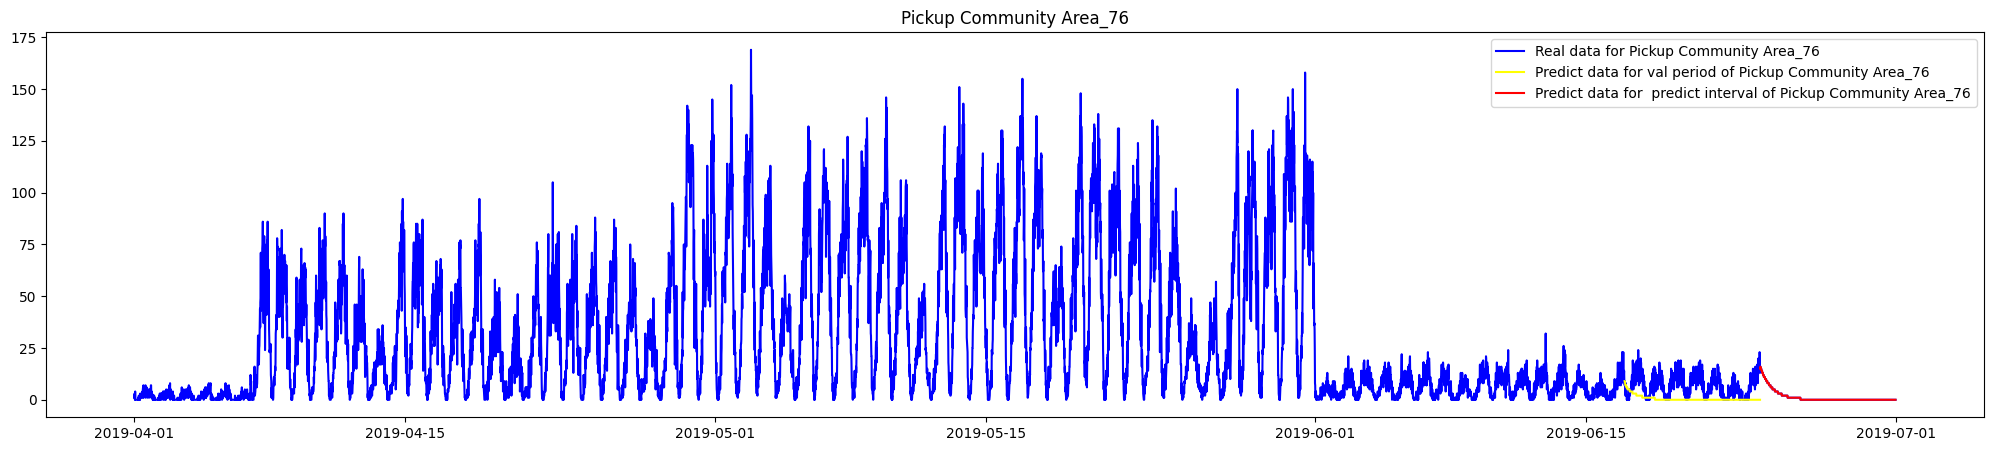

In [64]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_sarimax_predict[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

In [65]:
df_sarimax_predict['Pickup Community Area_76']

Trip Start Timestamp
2019-06-24 00:00:00    15.0
2019-06-24 00:15:00    16.0
2019-06-24 00:30:00    15.0
2019-06-24 00:45:00    15.0
2019-06-24 01:00:00    15.0
                       ... 
2019-06-30 22:45:00     0.0
2019-06-30 23:00:00     0.0
2019-06-30 23:15:00     0.0
2019-06-30 23:30:00     0.0
2019-06-30 23:45:00     0.0
Name: Pickup Community Area_76, Length: 672, dtype: float64

Считаем МАЕ для модели SARIMA

In [66]:
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

0.9073374542124543

Результат по модели SARIMA заносим в таблицу

In [67]:
df_results.loc[ len(df_results.index )] = ['SARIMA', round(res_mae, 2)]

## Bonus

1. Try to use machine learning algorithms for time series analysis. Make a prediction for each area for the next 673 intervals.
2. Try to use deep learning algorithms for time series analysis. Make a prediction for each area for the next 673 intervals.
3. Try to achieve an even better average MAE on the test dataset – 8.0.

---

1. Для анализа временных рядов используйте алгоритмы машинного обучения. Сделайте с их помощью прогноз для каждого района по всем  673 временным интервалам.
2. Для анализа временных рядов используйте алгоритмы глубокого обучения. Сделайте с их помощью прогноз для каждого района по всем  673 временным интервалам.
3. Постарайтесь достичь среднего значения MAE, равного не более 8,0 на тестовом наборе данных.

### ML
1. Для анализа временных рядов используйте алгоритмы машинного обучения. Сделайте с их помощью прогноз для каждого района по всем  673 временным интервалам.



Считываем данные в df_ml

In [68]:
df_ml = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_ml.fillna(0.0, inplace=True)

In [69]:
df_total = df.copy()
df_total = df_total.append(df_ml)

In [70]:
df_val_predict = df_val.copy() * 0.0
df_val_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature extraction

Добавим признаки для построения модели линейной регрессии. Стандартными признаками во временных рядах являются лаги (сдвиги) целевой переменной. Поскольку нас интересует недельный цикл, то, соответственно, берем три лага (сдвига) от 1 до 3 недель (672 = 4 * 96). Добавим три новых столбца в датафрейм. Далее - разбиваем данные на train/val/predict (см. prepare_data в utils.py) и с помощью модели LinearRegression делаем предсказания.

In [71]:
lags_list = [672, 1344, 2017]

for area in df_total:
	model_lr = LinearRegression()
	X_train, X_test, y_train, y_test, X_predict = prepare_data(df_total[area], lags_list)
	model_lr.fit(X_train, y_train)

	df_val_predict[area] = model_lr.predict(X_test)
	df_ml[area] = model_lr.predict(X_predict)
	# y_val = y_val_predict.copy()
	# y_val[y_val_predict < 0] = 0

Преобразуем в целые неотрицательные полученные результаты

In [72]:
df_ml = update_df(df_ml)
df_val_predict = update_df(df_val_predict)

In [73]:
df_val_predict.tail(70)

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 06:30:00,5.0,1.0,1.0,2.0,1.0,0.0,6.0,3.0,31.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0
2019-06-23 06:45:00,7.0,1.0,1.0,2.0,1.0,1.0,7.0,2.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0
2019-06-23 07:00:00,7.0,1.0,1.0,1.0,1.0,0.0,6.0,2.0,31.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0
2019-06-23 07:15:00,7.0,1.0,1.0,1.0,1.0,0.0,6.0,2.0,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0
2019-06-23 07:30:00,7.0,1.0,1.0,1.0,1.0,0.0,6.0,3.0,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-23 22:45:00,10.0,1.0,1.0,1.0,1.0,0.0,8.0,2.0,33.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,1.0
2019-06-23 23:00:00,8.0,1.0,1.0,2.0,1.0,0.0,7.0,3.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1.0
2019-06-23 23:15:00,9.0,1.0,1.0,2.0,1.0,0.0,7.0,3.0,27.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,2.0


Построим график предсказаний для 'Pickup Community Area_76'

In [74]:
df_total = df.copy()
df_total = df_total.append(df_ml)
df_total.tail(700)

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 17:00:00,7.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
2019-06-23 17:15:00,1.0,2.0,1.0,1.0,1.0,0.0,9.0,2.0,14.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0
2019-06-23 17:30:00,6.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,13.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0
2019-06-23 17:45:00,6.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0
2019-06-23 18:00:00,10.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,23.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 22:45:00,7.0,1.0,1.0,2.0,1.0,0.0,5.0,3.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,1.0
2019-06-30 23:00:00,6.0,1.0,1.0,2.0,1.0,0.0,7.0,2.0,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,1.0
2019-06-30 23:15:00,9.0,1.0,1.0,1.0,1.0,0.0,7.0,2.0,35.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,1.0


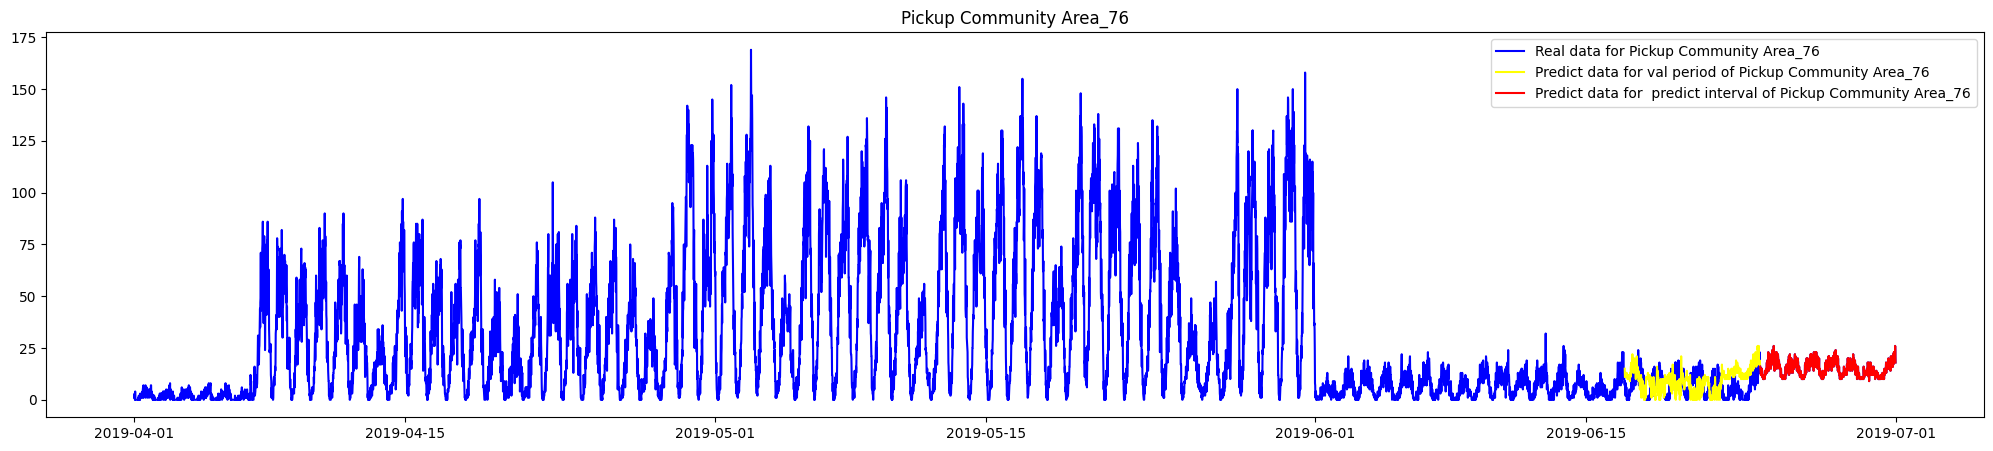

In [75]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_ml[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

Считаем МАЕ для модели LinearRegression

In [76]:
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

1.0847069597069599

Результат по модели LinearRegression заносим в таблицу

In [77]:
df_results.loc[ len(df_results.index )] = ['ML (Linear Regression)', round(res_mae, 2)]

## DS algorithm

2. Для анализа временных рядов используйте алгоритмы глубокого обучения. Сделайте с их помощью прогноз для каждого района по всем  673 временным интервалам.

Считываем данные в df_вы

In [78]:
df_ds = pd.read_csv('data/taxi_submission_file.csv', index_col='Trip Start Timestamp', parse_dates=True)
df_ds.fillna(0.0, inplace=True)

In [79]:
df_total = df.copy()
df_total = df_total.append(df_ds)

In [80]:
df_val_predict = df_val.copy() * 0.0
df_val_predict.tail()

,Pickup Community Area_0,Pickup Community Area_1,Pickup Community Area_2,Pickup Community Area_3,Pickup Community Area_4,Pickup Community Area_5,Pickup Community Area_6,Pickup Community Area_7,Pickup Community Area_8,Pickup Community Area_9,...,Pickup Community Area_68,Pickup Community Area_69,Pickup Community Area_70,Pickup Community Area_71,Pickup Community Area_72,Pickup Community Area_73,Pickup Community Area_74,Pickup Community Area_75,Pickup Community Area_76,Pickup Community Area_77
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-23 22:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-23 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Для предсказаний будем использовать однослойную LSTM модель

In [81]:
model_ds = Sequential()
model_ds.add(LSTM(672, activation='relu', input_shape=(1, 3, 1)))
model_ds.add(Dropout(0.3))
model_ds.add(Dense(1))
model_ds.add(Activation("relu"))
model_ds.compile(loss="mae", optimizer="adam")
model_ds.build(input_shape=(1, 3, 1))
model_ds.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrapp  (1, 672)                 1811712   
 er)                                                             
                                                                 
 dropout (Dropout)           (1, 672)                  0         
                                                                 
 dense (Dense)               (1, 1)                    673       
                                                                 
 activation (Activation)     (1, 1)                    0         
                                                                 
Total params: 1,812,385
Trainable params: 1,812,385
Non-trainable params: 0
_________________________________________________________________


Как и в предыдущей ml-модели, будем использовать признаки, полученные из лагов (сдвигов).

Входным вектором для LSTM является трехмерный массив (num_samples, num_time_steps, num_features). В нашем случае num_samples = 672 (число временных отрезков в текущий момент), num_time_steps = 3 (длина вектора (количество столбцов с данными из лагов)) и добавляем, сколько фич, а именно 1.

In [82]:
lags_list = [672, 1344, 2017]

for area in df_total:
	model_lr = LinearRegression()
	X_train, X_test, y_train, y_test, X_predict = prepare_data(df_total[area], lags_list)

	X_train = X_train.values
	X_test = X_test.values
	X_predict = X_predict.values

	X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
	X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
	X_predict = X_predict.reshape(X_predict.shape[0], X_predict.shape[1], 1)

	model_ds.fit(X_train, y_train, batch_size=672, epochs=5, validation_split= 1 / 11)

	df_val_predict[area] = model_ds.predict(X_test)
	df_ds[area] = model_ds.predict(X_predict)

Epoch 1/5
10/10 [==============================] - 3s 201ms/step - loss: 13.4108 - val_loss: 5.6555
Epoch 2/5
10/10 [==============================] - 2s 171ms/step - loss: 10.2121 - val_loss: 6.0611
Epoch 3/5
10/10 [==============================] - 2s 172ms/step - loss: 9.4372 - val_loss: 6.1128
Epoch 4/5
10/10 [==============================] - 2s 170ms/step - loss: 9.1348 - val_loss: 4.8731
Epoch 5/5
21/21 [==============================] - 0s 11ms/step
Epoch 1/5
10/10 [==============================] - 2s 172ms/step - loss: 1.0734 - val_loss: 0.4983
Epoch 2/5
10/10 [==============================] - 2s 173ms/step - loss: 1.0758 - val_loss: 0.4809
Epoch 3/5
10/10 [==============================] - 2s 187ms/step - loss: 1.0711 - val_loss: 0.4859
Epoch 4/5
10/10 [==============================] - 2s 177ms/step - loss: 1.0659 - val_loss: 0.4940
Epoch 5/5
21/21 [==============================] - 0s 13ms/step
Epoch 1/5
10/10 [==============================] - 2s 166ms/step - loss: 1.032

Преобразуем в целые неотрицательные полученные результаты

In [83]:
df_ds = update_df(df_ds)
df_val_predict = update_df(df_val_predict)

Построим график предсказаний для 'Pickup Community Area_76'

In [84]:
df_total = df.copy()
df_total = df_total.append(df_ds)

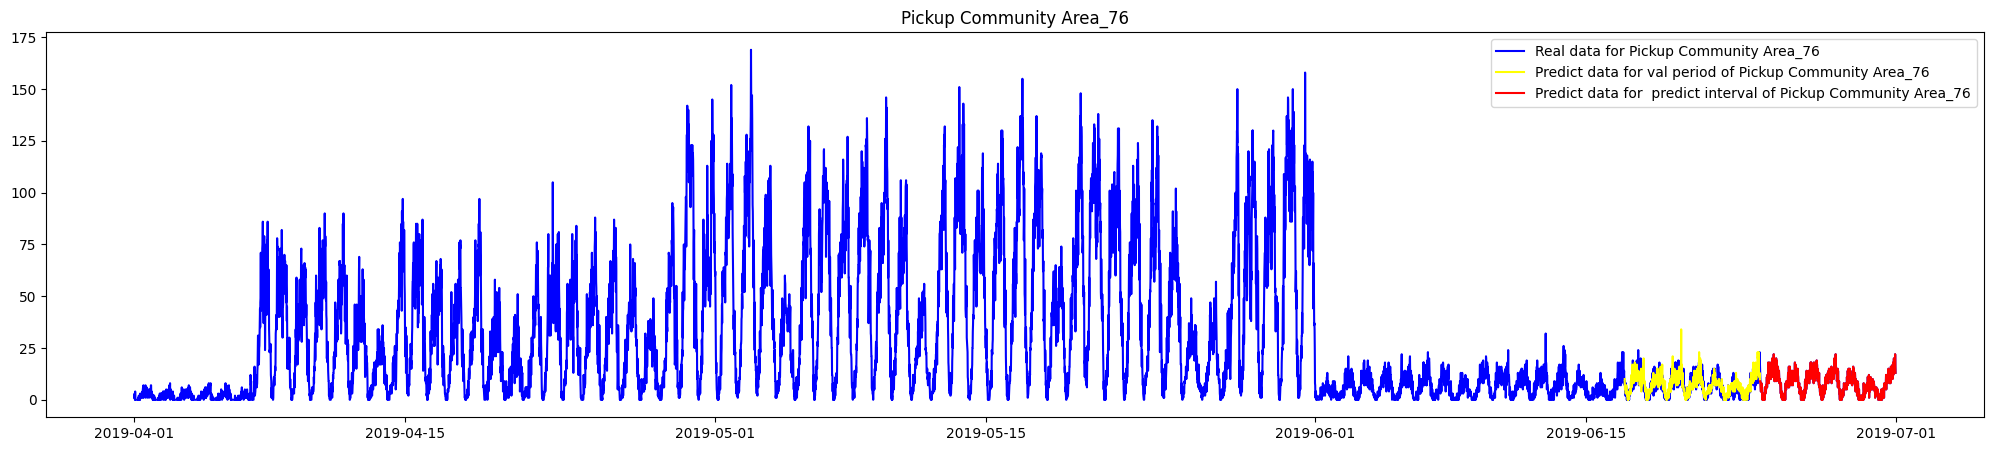

In [85]:
for area in df_total[df_total.columns[76:77]]:
	plt.figure(figsize=(25,5))
	plt.plot(df_total[area], label=f'Real data for {area}', color='blue')
	plt.plot(df_val_predict[area], label=f'Predict data for val period of {area}', color='yellow')
	plt.plot(df_ds[area], label=f'Predict data for  predict interval of {area}', color='red')
	plt.legend(loc='best')
	plt.title(area)
	plt.show()

Считаем МАЕ для модели LSTM

In [86]:
res_mae = mean_absolute_error(df_val, df_val_predict)
res_mae

0.5371642246642245

Результат по модели LinearRegression заносим в таблицу

In [87]:
df_results.loc[ len(df_results.index )] = ['DS (Long Short-Term Memory)', round(res_mae, 2)]

In [88]:
## Таблица с результатами

In [89]:
df_results.sort_values(by='MAE')

,Model_name,MAE
1,* Moving averages with window 2,0.20
2,* Moving averages with window 4,0.25
11,DS (Long Short-Term Memory),0.54
3,* Moving averages with window 96,0.59
4,Moving averages with window 672,0.61
6,Simple Exponential Smoothing (Braun),0.72
8,Exponential Smoothing (Holt-Winters),0.77
7,Exponential Smoothing (Holt),0.86
9,SARIMA,0.91
10,ML (Linear Regression),1.08


Сохраняем результаты с лучшим результатом по МАЕ в файл data/best_taxi_submission_file.csv

In [90]:
df_ds.to_csv('data/best_taxi_submission_file.csv')